In [1]:
### import all modules

import sys
import os
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import joblib
from joblib import Parallel, delayed
import copy
from openbabel import openbabel
from openbabel import pybel
import openbabel as ob
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
#from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDistGeom
import re
import multiprocessing
import math

In [32]:
### user specified inputs & check if the csv is read in correctly
### all the .ct files of the fragemnts
### the .csv file with all the properties for each of the node

charge_specificed = 0                     ### total charge of the species generated
monomers = 2                              ### max number of repeated nodes from the .csv file to include in the species
donor_M_connection = 6                    ### additional setting for the max number of connections with M and donor
donor_as_bridgeing = False                ### True if the donor ligand used to describe charged multidentate ligand.
center = ['Mg', 'Na']                     ### metal centers to filter out 3D structures with atoms too close to the metal atoms. 
df = pd.read_csv('components-data.csv')   ### name of the fragment property .csv file
user_specified_atomcount_controll = []    ### [('componenet1', 2), ('componenet2',1)] to controll the max number of a fragment's presence
bonds_not_constructed = [('Na', 'R')]     ### [('componenet1', 'componenet2'), (.. , ..)]
num_cores = 7                             ### number of cores to be used, 7 for an 8 core computer etc.
dummy_atom_needed = ['Mg', 'Li']          ### ['real atom', 'dummy atom'] 


### print out the read .csv to confirm the inputs
#for index, col in df.iterrows():
    #print(col['components'])
from ast import literal_eval
#df['connectivity allowed2'] = df['connectivity allowed'].apply(lambda cell: list(literal_eval(cell)))
df['connectivity allowed'] = df['connectivity allowed'].apply(lambda cell: [int(el) for el in cell.split(', ')])
print(df)

   components  charge connectivity allowed donor atom    type
0          Na       1      [0, 1, 2, 3, 4]         Na   metal
1          Mg       2      [0, 1, 2, 3, 4]         Mg   metal
2        OEt2       0               [0, 1]          O  ligand
3           R      -1               [0, 1]          C  ligand
4  DonorLN2N1      -1               [0, 1]          N  ligand
5  DonorLN2N2      -1            [0, 1, 2]          N  ligand


In [3]:
### a function to plot graphs, called later on
def plot_graphs(graphs):
    """Utility to plot a lot of graphs from an array of graphs. 
    Each graphs is a list of edges; each edge is a tuple."""
    figsize=20
    dotsize=20
    n = len(graphs)
    GRAPHS = []
    fig = plt.figure(figsize=(figsize,figsize))
    fig.patch.set_facecolor('white') # To make copying possible (no transparent background)
    k = int(np.sqrt(n))


    G = nx.Graph(label="x")
    for i in range(0, len(nodes)):
        #print(i)
        G.add_nodes_from([
            (i, {"label": nodes[i]}),
            ])
    
    
    
    for i in range(n):
        plt.subplot(k+1,k+1,i+1)
        Edges = list(G.edges)
        G.remove_edges_from(Edges)
        Nodes = list(G.nodes)
        G.remove_nodes_from(Nodes)
    
        for edge in graphs[i]:
            G.add_edge(edge[0],edge[1])
        
        for node in list(G.nodes):
            G.add_nodes_from([
                (node, {'label': nodes[node]}),
                ])
    
        Gtemp = G.copy()
        GRAPHS.append(Gtemp)
    
        labels = nx.get_node_attributes(G,'label')
        pos = nx.spring_layout(G, scale=5, k=5/np.sqrt(G.order()))
        nx.draw_networkx(G, pos, node_color='lightblue', node_size=500, labels = labels, width = 2, font_size=13, alpha=1, edge_color="black")
        #nx.draw_kamada_kawai(G, node_size=dotsize)
        #print('.', i, end='')
        
        print('.', end='')

In [4]:
### get the total charge of the donor ligand

nodes = []
charges = []
donor_atoms = []
for index, col in df.iterrows():
    nodes.append(col['components'])
    charges.append(col['charge'])
    donor_atoms.append(col['donor atom'])

donor_nodx_atoms = []
donor_total_charge = 0
for node in nodes:
    if 'Donor' in node:
        donor_total_charge = donor_total_charge + charges[nodes.index(node)]
        donor_nodx_atoms.append(donor_atoms[nodes.index(node)])
print(donor_total_charge)
#print(donor_nodx_atoms)


-2


In [5]:
### generating all the nodes

nodes = []
connectivity_allowed = []
charges = []
donor_atoms = []
type =[]
for i in range (0, monomers):
    for index, col in df.iterrows():
        nodes.append(col['components'])
        charges.append(col['charge'])
        connectivity_allowed.append(col['connectivity allowed'])
        donor_atoms.append(col['donor atom'])
        type.append(col['type'])
print(nodes)
print(charges)
print(connectivity_allowed)
print(type)

if dummy_atom_needed != []:
    donor_atoms = [dummy_atom_needed[1] if t == dummy_atom_needed[0] else t for t in donor_atoms]
print(donor_atoms)

['Na', 'Mg', 'OEt2', 'R', 'DonorLN2N1', 'DonorLN2N2', 'Na', 'Mg', 'OEt2', 'R', 'DonorLN2N1', 'DonorLN2N2']
[1, 2, 0, -1, -1, -1, 1, 2, 0, -1, -1, -1]
[[0, 1, 2, 3, 4], [0, 1, 2, 3, 4], [0, 1], [0, 1], [0, 1], [0, 1, 2], [0, 1, 2, 3, 4], [0, 1, 2, 3, 4], [0, 1], [0, 1], [0, 1], [0, 1, 2]]
['metal', 'metal', 'ligand', 'ligand', 'ligand', 'ligand', 'metal', 'metal', 'ligand', 'ligand', 'ligand', 'ligand']
['Na', 'Li', 'O', 'C', 'N', 'N', 'Na', 'Li', 'O', 'C', 'N', 'N']


In [6]:
### check if the donor ligand (otherwords multidentate liand is charged or not)

Donorligand_charged = False
for node in nodes:
    if 'Donor' in node:
        Donorligand_charge = charges[nodes.index(node)]
        if Donorligand_charge != 0:
            Donorligand_charged = True
            break
print (Donorligand_charged)

True


In [7]:
### here is building the edges

import itertools
n = len(nodes)
out = []
all_possible_edges = []
for i, j in itertools.combinations(list(range(n)), 2):
    all_possible_edges.append((i,j))
print(all_possible_edges)


[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (7, 8), (7, 9), (7, 10), (7, 11), (8, 9), (8, 10), (8, 11), (9, 10), (9, 11), (10, 11)]


In [8]:
### filter out unwanted edges between 2 atoms

import copy
all_possible_edges_filtered = copy.copy(all_possible_edges)


for edge in all_possible_edges:
    if type[edge[0]] == type[edge[1]]:
        i=all_possible_edges.index(edge)
        all_possible_edges_filtered[i] = 'tbr'
    for n in bonds_not_constructed:
        if nodes[edge[0]] in n and nodes[edge[1]] in n:
            i=all_possible_edges.index(edge) 
            all_possible_edges_filtered[i] = 'tbr'

#print(all_possible_edges_filtered)

all_possible_edges_filtered2 = []
for edges in all_possible_edges_filtered:
    if edges != 'tbr':
        all_possible_edges_filtered2.append(edges)

print(all_possible_edges_filtered2)


[(0, 2), (0, 4), (0, 5), (0, 8), (0, 10), (0, 11), (1, 2), (1, 3), (1, 4), (1, 5), (1, 8), (1, 9), (1, 10), (1, 11), (2, 6), (2, 7), (3, 7), (4, 6), (4, 7), (5, 6), (5, 7), (6, 8), (6, 10), (6, 11), (7, 8), (7, 9), (7, 10), (7, 11)]


In [9]:
### here we would like to group the donor ligand nodes and the non-donor ligand nodes to reduce the combinatorial explosion

edges_nodonor = []
edges_donor = []
for edges in all_possible_edges_filtered2:
    
    if 'Donor' not in nodes[edges[0]] and 'Donor' not in nodes[edges[1]]:
        edges_nodonor.append(edges)
    else:
        edges_donor.append(edges)
print(edges_nodonor)
print(edges_donor)


[(0, 2), (0, 8), (1, 2), (1, 3), (1, 8), (1, 9), (2, 6), (2, 7), (3, 7), (6, 8), (7, 8), (7, 9)]
[(0, 4), (0, 5), (0, 10), (0, 11), (1, 4), (1, 5), (1, 10), (1, 11), (4, 6), (4, 7), (5, 6), (5, 7), (6, 10), (6, 11), (7, 10), (7, 11)]


In [10]:
#************************************************* non donor graphs ****************************************************

In [11]:
### generating combinations of non donor edges

from joblib import Parallel, delayed
import itertools
import multiprocessing

def generate_combinations(length, max_index):
    """
    Generate all combinations of a given length.
    """
    result = list(itertools.combinations(range(max_index), length))
    print(f"[PID {multiprocessing.current_process().pid}] Finished length {length} with {len(result)} combinations")
    return result


max_index = len(edges_nodonor)

# Parallelize with basic print-based progress tracking
results = Parallel(n_jobs=num_cores)(
    delayed(generate_combinations)(length, max_index) for length in range(1, max_index + 1)
)

# Flatten
all_possible_combinations = [item for sublist in results for item in sublist]

print("Total combinations:", len(all_possible_combinations))


Total combinations: 4095


In [12]:
### now we make all combinations of no donor containing components into graphs

tempall_possible_nodonor_graphs = []
for combinations in all_possible_combinations:
    edges = []
    #print (combinations)
    for edge in combinations:
        #print (edge)
        edges.append(edges_nodonor[int(edge)])
    tempall_possible_nodonor_graphs.append(edges)
print(len(tempall_possible_nodonor_graphs))


G = nx.Graph(label="x")

4095


In [13]:
### and filter them by connection

import copy
filtered2_nodonor_combinations = copy.copy(tempall_possible_nodonor_graphs)

for i in range(0, len(tempall_possible_nodonor_graphs)):
    G.clear()
    #print(i)
    
    for edge in tempall_possible_nodonor_graphs[i]:            
        G.add_edge(edge[0],edge[1])
        
    for node in list(G.nodes):
        degrees = nx.degree(G, nbunch=node)
        #print(node)    
        if degrees not in connectivity_allowed[node]:
            #print(degrees)
            filtered2_nodonor_combinations[i] = 'tbr'
            break
            
filtered3_nodonor_combinations = []
for edge in filtered2_nodonor_combinations:
    if edge != 'tbr':
        filtered3_nodonor_combinations.append(edge)

print (len(filtered3_nodonor_combinations))

224


In [14]:
### continue filter by charge, if donor ligand is not charged

filtered4_nodonor_combinations = []
filteredcomplete_nodonor_combinations = []

if Donorligand_charged == True:
    filtered4_nodonor_combinations = filtered3_nodonor_combinations  # No need to filter further
    print('no charge filter')
else:
    print('yes charge filter')
    for i in range(0, len(filtered3_nodonor_combinations)):
        Edges = list(G.edges)  
        G.clear()
        for edge in filtered3_nodonor_combinations[i]:            
            G.add_edge(edge[0], edge[1])
        charge = 0 

        for node in list(G.nodes):
            charge = charge + charges[node] 
        # Now filter based on specified charge
        if charge == charge_specificed:
            filtered4_nodonor_combinations.append(filtered3_nodonor_combinations[i])

print(len(filtered4_nodonor_combinations))

no charge filter
224


In [15]:
### filter out the isomorph graphs 

graphs = []
filtered5_nodonor_combinations = []
filtered5_nodonor_graphs = []

G = nx.Graph(label="x")
for i in range(0, len(nodes)):
    #print(i)
    G.add_nodes_from([
        (i, {"label": nodes[i]}),
        ])

for i in range(0, len(filtered4_nodonor_combinations)):
    Edges = list(G.edges)
    G.remove_edges_from(Edges)
    
    for edge in filtered4_nodonor_combinations[i]:            
        G.add_edge(edge[0],edge[1])
    
    graphs.append(nx.weisfeiler_lehman_graph_hash(G, node_attr='label'))


for i in range(0, len(graphs)):
    if graphs[i] not in filtered5_nodonor_graphs:
        filtered5_nodonor_combinations.append(filtered4_nodonor_combinations[i])
        filtered5_nodonor_graphs.append(graphs[i])


filteredcomplete_nodonor_combinations = filtered5_nodonor_combinations

print (len(filteredcomplete_nodonor_combinations))

37


In [16]:
### user specificed controll of atom number filter if specified above:

filtered6_nodonor_combinations = []
filtered_edges = copy.copy(filtered5_nodonor_combinations)

if user_specified_atomcount_controll:
    print ('now filter according to user defined atom_num')
    for i in range(0, len(filtered5_nodonor_combinations)):
        Edges = list(G.edges)
        G.clear()
        G.remove_edges_from(Edges)
        for edge in filtered5_nodonor_combinations[i]:            
            G.add_edge(edge[0],edge[1])
        charge = 0
    
        #print(list(G.nodes))

        for atom, num in user_specified_atomcount_controll:
            count = 0
            for node in list(G.nodes):
                if nodes[node] == atom:
                    count+=1
            if count != num:
                filtered_edges[i] = 'tbr'
                break

    for edges in filtered_edges:
        #print (edges)
        if edges != 'tbr':
            filtered6_nodonor_combinations.append(edges)
            #print (filtered6_nodonor_combinations)
        
    filteredcomplete_nodonor_combinations = copy.copy(filtered6_nodonor_combinations)
print (len(filteredcomplete_nodonor_combinations))
#print (filteredcomplete_nodonor_combinations)

37


In [17]:
### if the donor set as charged multidentate ligands then no structure should be presented here to satisfy charge

if donor_as_bridgeing:
    filteredcomplete_nodonor_combinations.append([])

.........

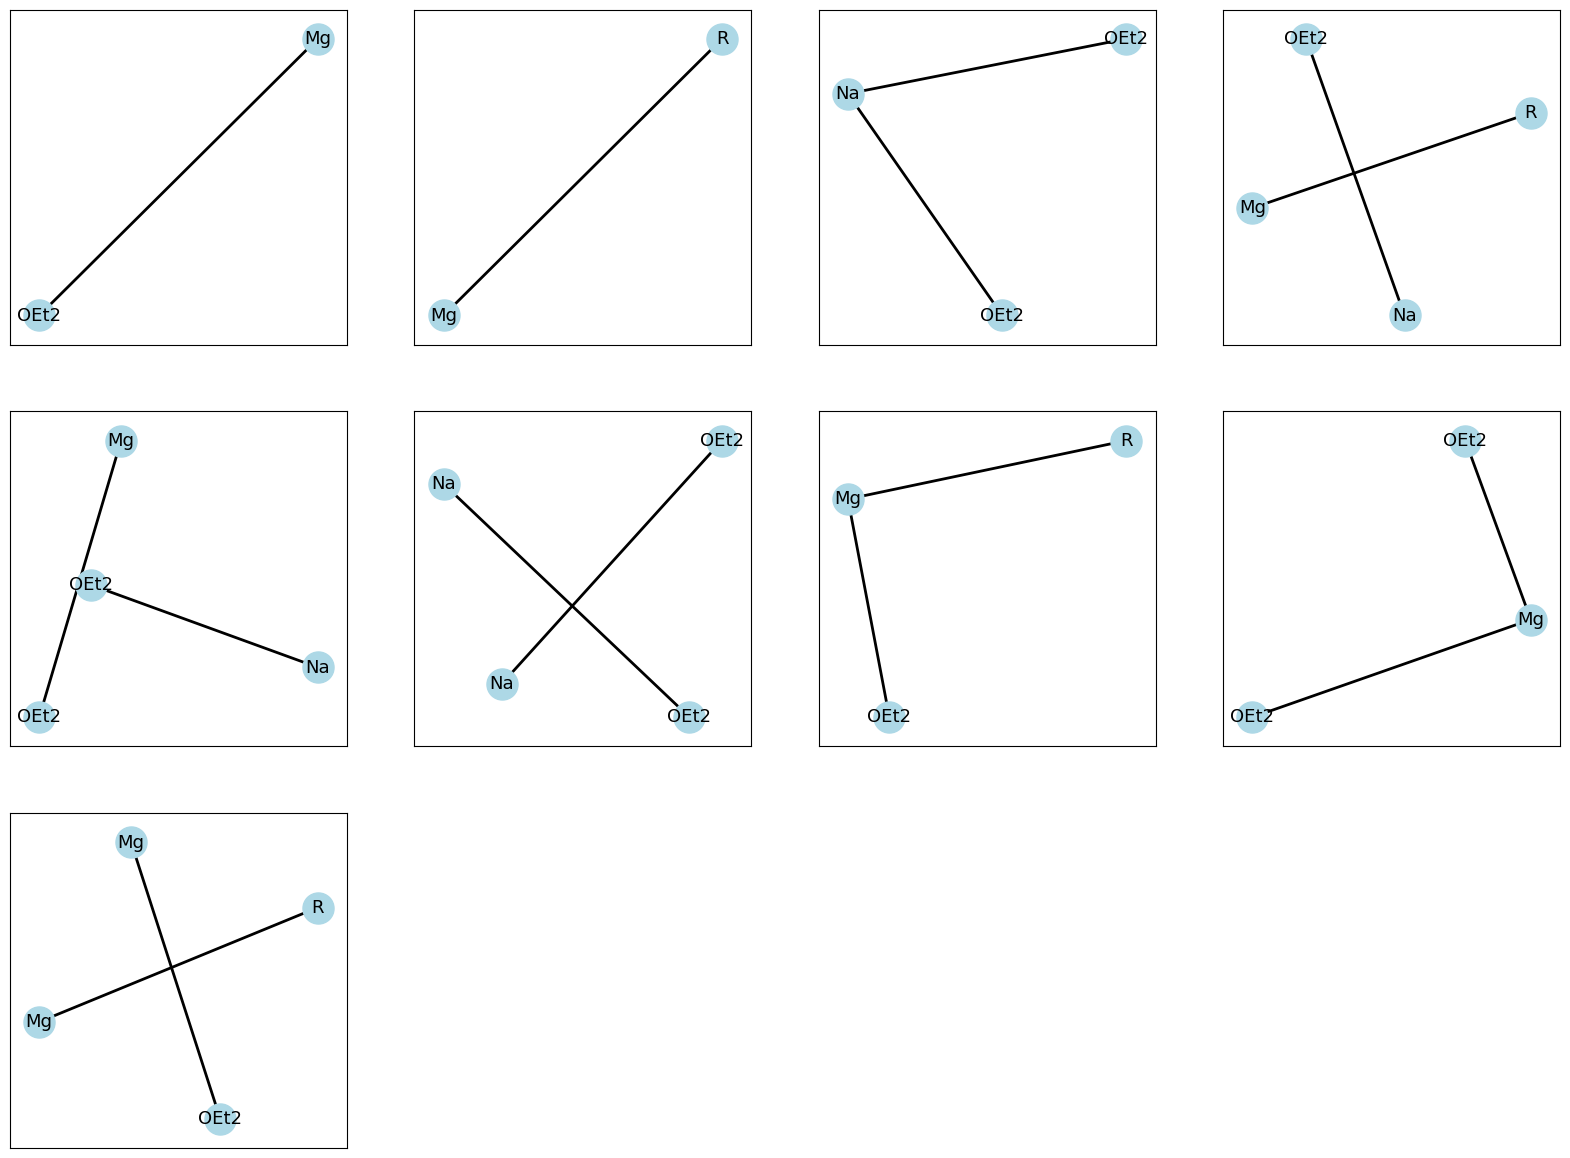

In [18]:
### plot and check a subset of the graphs

plot_graphs(filteredcomplete_nodonor_combinations[1:10])

In [19]:
#************************************************* donor graphs ****************************************************

In [37]:
### check if there maybe a combinatorial explosion

combinatorial_explosion = False

temp_all_possible_combinations = []
for node in nodes:
    if 'Donor' in node:
        if type[nodes.index(node)] == 'metal': 
            combinatorial_explosion = True


### if there is expected to be a combinatorial explosion the following filter process is applied to ensure completion

if combinatorial_explosion == True:
    print ('!!!combinatorial_explosion occurs, using flying edge method!!!')

    
### Collect all unique nodes from non-donor graphs
    valid_nodes = []
    for edges in filteredcomplete_nodonor_combinations:
        for i, j in edges:
            if i not in valid_nodes:
                valid_nodes.append(i)
            if j not in valid_nodes:
                valid_nodes.append(j)
    print (valid_nodes)

    
### Filter edges_donor based on donor labeling and node validity
    valid_donoredges_donor = []
    valid_metaledges_donor = []
    
    for i, j in edges_donor:
        #print (nodes)
        if 'Donor' in nodes[i] and 'Donor' in nodes[j]:
            if abs(i - j) >= ((len(nodes))//monomers):
                valid_donoredges_donor.append((i, j))
            #print((nodes[i], nodes[j]))
        elif i in valid_nodes or j in valid_nodes:
            for n in bonds_not_constructed:
                if nodes[i] not in n and nodes[j] not in n:
                    valid_metaledges_donor.append((i, j))
                else:
                    print (i,j)
            #print((i, j))
    print (valid_metaledges_donor)
    print (valid_donoredges_donor)

    
### generating all combinations of M-donor edges
    
    temp_all_possible_combinations = []

    for length in range(1,int(monomers*donor_M_connection)):
        print(length)
        combinations = list(itertools.combinations(list(range(len(valid_metaledges_donor))), length))
        temp_all_possible_combinations = temp_all_possible_combinations + combinations
    print(len(temp_all_possible_combinations))
    tempall_possible_graphs = []
    for combinations in temp_all_possible_combinations:
        edges = []
        #print (combinations)
        for edge in combinations:
            #print (edge)
            edges.append(valid_metaledges_donor[int(edge)])
        tempall_possible_graphs.append(edges)
    print(len(tempall_possible_graphs))


### filter M-donor edges based on connectivities defined in the .csv file
    
    def filter_graph(index, graph, connectivity_allowed):
        """
        Check if the graph at the given index meets the specified connectivity criteria.
        If not, mark it as 'tbr' (to be removed).
        """
        G = nx.Graph()  # Create a new graph instance for this function
        for edge in graph:
            G.add_edge(edge[0], edge[1])
    
        for node in list(G.nodes):
            degrees = G.degree(node)
            if degrees not in connectivity_allowed[node]:
                return 'tbr'
        return graph

# Parallelize the filtering process
    filtered2_combinations = copy.copy(tempall_possible_graphs)
    results = Parallel(n_jobs=num_cores)(delayed(filter_graph)(i, graph, connectivity_allowed) for i, graph in enumerate(tempall_possible_graphs))
    filtered2_combinations = results
    filtered3_combinations = [graph for graph in filtered2_combinations if graph != 'tbr']
    print(len(filtered3_combinations))

    
### this restricts the number of donor metal interactions as specified by the user 
    
    import copy
    filtered4_combinations = copy.copy(filtered3_combinations)


    for i in range(0, len(filtered3_combinations)):
        G.clear()
        #print(i)
        for edge in filtered3_combinations[i]:            
            G.add_edge(edge[0],edge[1])
        
        for node in list(G.nodes):
            donor_metal = nx.degree(G, nbunch=node)
            if donor_metal > donor_M_connection:
                #print('yes')
                filtered4_combinations[i] = 'tbr'
                break
            
    filtered5_combinations = []
    for edges in filtered4_combinations:
        if edges != 'tbr':
            filtered5_combinations.append(edges)


    print (len(filtered5_combinations))

    
### filter isomorph graphs 
    def compute_graph_hash(edges, node_labels):
        # Create a local graph instance for this set of edges
        local_G = nx.Graph()
        local_G.add_nodes_from([(i, {"label": label}) for i, label in enumerate(node_labels)])
        local_G.add_edges_from(edges)
    
        # Compute and return the Weisfeiler-Lehman graph hash
        return nx.weisfeiler_lehman_graph_hash(local_G, node_attr='label')

    node_labels = nodes
    # Parallelize the computation of graph hashes
    graphs_hashes = Parallel(n_jobs=num_cores)(delayed(compute_graph_hash)(edges, node_labels) for edges in filtered5_combinations)
    # Sequential part: filtering unique graphs based on hashes
    filtered5_edges = []
    filtered5_graphs = []
    for i, graph_hash in enumerate(graphs_hashes):
        if graph_hash not in filtered5_graphs:
            filtered5_edges.append(filtered5_combinations[i])
            filtered5_graphs.append(graph_hash)
    print(len(filtered5_edges))

    
### generate all combinations of the donor-donor edges
    
    donortemp_all_possible_combinations = []
    combinations = []
    for length in range(1,int(len(valid_donoredges_donor)/monomers)+1):
        print(length)
        combinations = list(itertools.combinations(list(range(len(valid_donoredges_donor))), length))
        donortemp_all_possible_combinations = donortemp_all_possible_combinations + combinations
    print(len(donortemp_all_possible_combinations))
    donortempall_possible_graphs = []
    for combinations in donortemp_all_possible_combinations:
        edges = []
        #print (combinations)
        for edge in combinations:
            #print (edge)
            edges.append(valid_donoredges_donor[int(edge)])
        donortempall_possible_graphs.append(edges)
    print(len(donortempall_possible_graphs))

    
### filter the donor-donor graphs based on connectivity allowed
    
    def filter_graph(index, graph, connectivity_allowed):
        """
        Check if the graph at the given index meets the specified connectivity criteria.
        If not, mark it as 'tbr' (to be removed).
        """
        G = nx.Graph()  # Create a new graph instance for this function
        for edge in graph:
            G.add_edge(edge[0], edge[1])
    
        for node in list(G.nodes):
            degrees = G.degree(node)
            if degrees not in connectivity_allowed[node]:
                return 'tbr'
        return graph

    donorfiltered2_combinations = copy.copy(donortempall_possible_graphs)
    results = Parallel(n_jobs=num_cores)(delayed(filter_graph)(i, graph, connectivity_allowed) for i, graph in enumerate(donortempall_possible_graphs))
    donorfiltered2_combinations = results
    donorfiltered3_combinations = [graph for graph in donorfiltered2_combinations if graph != 'tbr']
    print(len(donorfiltered3_combinations))

### filter isomorph graphs 
    
    def compute_graph_hash(edges, node_labels):
        # Create a local graph instance for this set of edges
        local_G = nx.Graph()
        local_G.add_nodes_from([(i, {"label": label}) for i, label in enumerate(node_labels)])
        local_G.add_edges_from(edges)
    
        # Compute and return the Weisfeiler-Lehman graph hash
        return nx.weisfeiler_lehman_graph_hash(local_G, node_attr='label')

    node_labels = nodes
    # Parallelize the computation of graph hashes
    graphs_hashes = Parallel(n_jobs=num_cores)(delayed(compute_graph_hash)(edges, node_labels) for edges in donorfiltered3_combinations)
    # Sequential part: filtering unique graphs based on hashes
    donorfiltered3_edges = []
    donorfiltered3_graphs = []
    for i, graph_hash in enumerate(graphs_hashes):
        if graph_hash not in donorfiltered3_graphs:
            donorfiltered3_edges.append(donorfiltered3_combinations[i])
            donorfiltered3_graphs.append(graph_hash)
    print(len(donorfiltered3_edges))

    
### make all combinations of filtered M-donor and donor-donor graphs
    
    filteredcomplete_donor_combinations = []

    for c in filtered5_edges:
        filteredcomplete_donor_combinations.append(c)
        for cc in donorfiltered3_edges:
            edge = cc + c
            filteredcomplete_donor_combinations.append(edge)
    print (len(filteredcomplete_donor_combinations))    
    plot_graphs(filteredcomplete_donor_combinations[300:324])  

In [38]:
### if there is not expected to be a combinatorial explosion then the following general filtering procedure will be used
### NOTE: there is no gain or loss of the different filtering processes if the code decides there is not a combinatorial explosion using the previous script will not provide any speed up.

if not combinatorial_explosion:
    print('normal combination')

### generate all combination of donor involved edges
    
    max_index = len(edges_donor)
    if donor_as_bridgeing == True:
        max_length = int(max_index)
    else:
        max_length = int(max_index/monomers)

    def generate_donor_combinations(length, max_index):
        result = list(itertools.combinations(range(max_index), length))
        print(f"[PID {multiprocessing.current_process().pid}] Length {length} done with {len(result)} combinations")
        return result

    # Run parallel jobs
    results = Parallel(n_jobs=num_cores)(
        delayed(generate_donor_combinations)(length, max_index)
        for length in range(1, max_length + 1)
    )
    # Flatten
    temp_all_possible_combinations = [item for sublist in results for item in sublist]
    print("Total combinations:", len(temp_all_possible_combinations))

normal combination
Total combinations: 39202


In [39]:
### make graphs of all combinations of donors edges

if combinatorial_explosion == False:
    print ('normal combination')
    tempall_possible_graphs = []
    for combinations in temp_all_possible_combinations:
        edges = []
        #print (combinations)
        for edge in combinations:
            #print (edge)
            edges.append(edges_donor[int(edge)])
        tempall_possible_graphs.append(edges)
    print(len(tempall_possible_graphs))

normal combination
39202
[PID 45962] Finished length 10 with 66 combinations
[PID 45962] Length 4 done with 1820 combinations
[PID 45962] Length 6 done with 8008 combinations


In [24]:
### filters out any graphs with unwanted edges of the donor containing components

if combinatorial_explosion == False:
    print ('normal combination')
    def filter_graph(index, graph, connectivity_allowed):
        """
        Check if the graph at the given index meets the specified connectivity criteria.
        If not, mark it as 'tbr' (to be removed).
        """
        G = nx.Graph()  # Create a new graph instance for this function
        for edge in graph:
            G.add_edge(edge[0], edge[1])
    
        for node in list(G.nodes):
            degrees = G.degree(node)
            if degrees not in connectivity_allowed[node]:
                return 'tbr'
        return graph

    filtered2_combinations = copy.copy(tempall_possible_graphs)
    # Parallelize the filtering process
    results = Parallel(n_jobs=num_cores)(delayed(filter_graph)(i, graph, connectivity_allowed) for i, graph in enumerate(tempall_possible_graphs))
    # Update filtered2_combinations with the results
    filtered2_combinations = results
    # Filter out the graphs marked as 'tbr'
    filtered3_combinations = [graph for graph in filtered2_combinations if graph != 'tbr']

    print(len(filtered3_combinations))

normal combination
3024


In [40]:
### this filter restricts the number of donor metal interactions as user specified

if combinatorial_explosion == False:
    print ('normal combination')
    
    import copy
    filtered4_combinations = copy.copy(filtered3_combinations)


    for i in range(0, len(filtered3_combinations)):
        G.clear()
        #print(i)
        for edge in filtered3_combinations[i]:            
            G.add_edge(edge[0],edge[1])
        
        for node in list(G.nodes):
            donor_metal = nx.degree(G, nbunch=node)
            if donor_metal > donor_M_connection:
                #print('yes')
                filtered4_combinations[i] = 'tbr'
                break
            

    filtered5_combinations = []
    for edges in filtered4_combinations:
        if edges != 'tbr':
            filtered5_combinations.append(edges)
    
    filteredcomplete_donor_combinations = filtered5_combinations
    print (len(filtered5_combinations))
    #plot_graphs(filtered5_combinations[100:110])

normal combination
3024


In [26]:
#*************************************************create all graphs****************************************************

In [41]:
### make all combinations of donor and non-donor involved edges


edges = []

for c in filteredcomplete_nodonor_combinations:
    for cc in filteredcomplete_donor_combinations:
        edge = cc + c
        edges.append(edge)
print (len(edges))    

111888


In [43]:
### this filters any graphs that are incorrectly charged

filtered6_edges = []
if Donorligand_charged == True:
    #filtered4_nodonor_combinations = filtered3_nodonor_combinations  # No need to filter further
    for i in range(0, len(edges)):
        Edges = list(G.edges)
        G.clear()
        G.remove_edges_from(Edges)
        for edge in edges[i]:            
            G.add_edge(edge[0],edge[1])
        charge = 0
    
        #print(list(G.edges))

        Donornodes = []
        Donor_charges = 0
        for node in list(G.nodes):
            if 'Donor' in nodes[node]:
                Donornodes.append(node)
            else: 
                charge = charge + charges[node]
                
        for c in range(monomers):
            start = c * ((len(nodes))//monomers)
            end = start + ((len(nodes))//monomers)
            current_range = range(start, end)
            if any(d in current_range for d in Donornodes):
                Donor_charges += donor_total_charge
                continue
        #print ('total donor charge:')
        #print (Donor_charges)
        charge = charge + Donor_charges
        #print (charge)
        if charge == charge_specificed:
            filtered6_edges.append(edges[i])
            #print ('yes')
    
    print('donor charge filter')
    print(len(filtered6_edges))
else:
    print('no donor charge filter')
    for i in range(0, len(edges)):
        Edges = list(G.edges)
        G.clear()
        G.remove_edges_from(Edges)
        for edge in edges[i]:            
            G.add_edge(edge[0],edge[1])
        charge = 0
    
        #print(list(G.nodes))

    
        for node in list(G.nodes):
            charge = charge + charges[node]
            #print (node, charges[node])
        #print (charge)
        if charge == charge_specificed:
            filtered6_edges.append(edges[i])
            #print ('yes')
    print(len(filtered6_edges))

donor charge filter
47840


.........

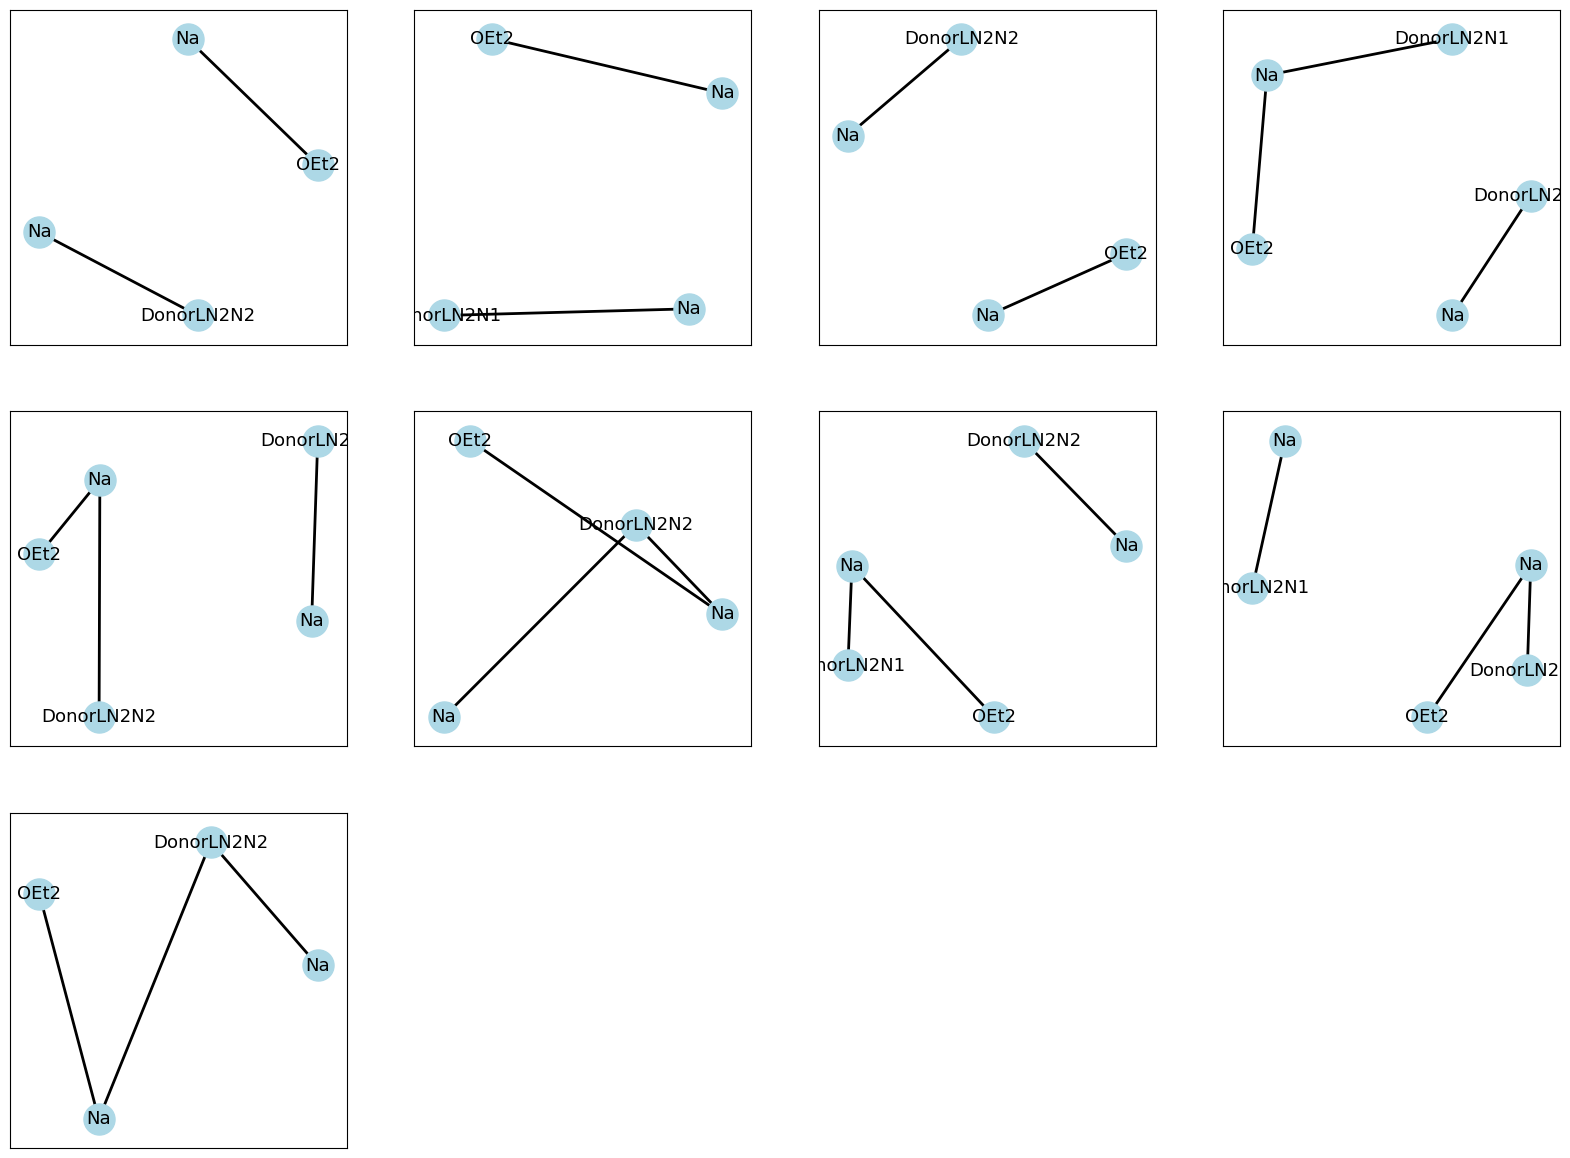

In [44]:
plot_graphs(filtered6_edges[1:10])

In [45]:
### this filters out any graphs with not allowed edges

G = nx.Graph(label="x")
for i in range(0, len(nodes)):
    #print(i)
    G.add_nodes_from([
        (i, {"label": nodes[i]}),
        ])

a = nx.get_node_attributes(G,'label')
print(a)

import copy
filtered_edges = copy.copy(filtered6_edges)


for i in range(0, len(filtered6_edges)):
    Edges = list(G.edges)
    G.remove_edges_from(Edges)
    for edge in filtered6_edges[i]:            
        G.add_edge(edge[0],edge[1])
        if a[edge[0]] == a[edge[1]]:
            filtered_edges[i] = 'tbr'
            #print ('1111')
            break
    for node, attribute in a.items():
        degrees = nx.degree(G, nbunch=node)
        if degrees not in connectivity_allowed[node]:
            #print (degrees, connectivity_allowed[node])
            filtered_edges[i] = 'tbr'
            #print ('2222')
            break
            

filtered2_edges = []
for edge in filtered_edges:
    if edge != 'tbr':
        filtered2_edges.append(edge)
print (len(filtered2_edges))


# here we add again all the filter graphs for all graphs without donor atoms
for c in filteredcomplete_nodonor_combinations:
    filtered2_edges.append(c)



print (len(filtered2_edges))

{0: 'Na', 1: 'Mg', 2: 'OEt2', 3: 'R', 4: 'DonorLN2N1', 5: 'DonorLN2N2', 6: 'Na', 7: 'Mg', 8: 'OEt2', 9: 'R', 10: 'DonorLN2N1', 11: 'DonorLN2N2'}
43623
43660


............

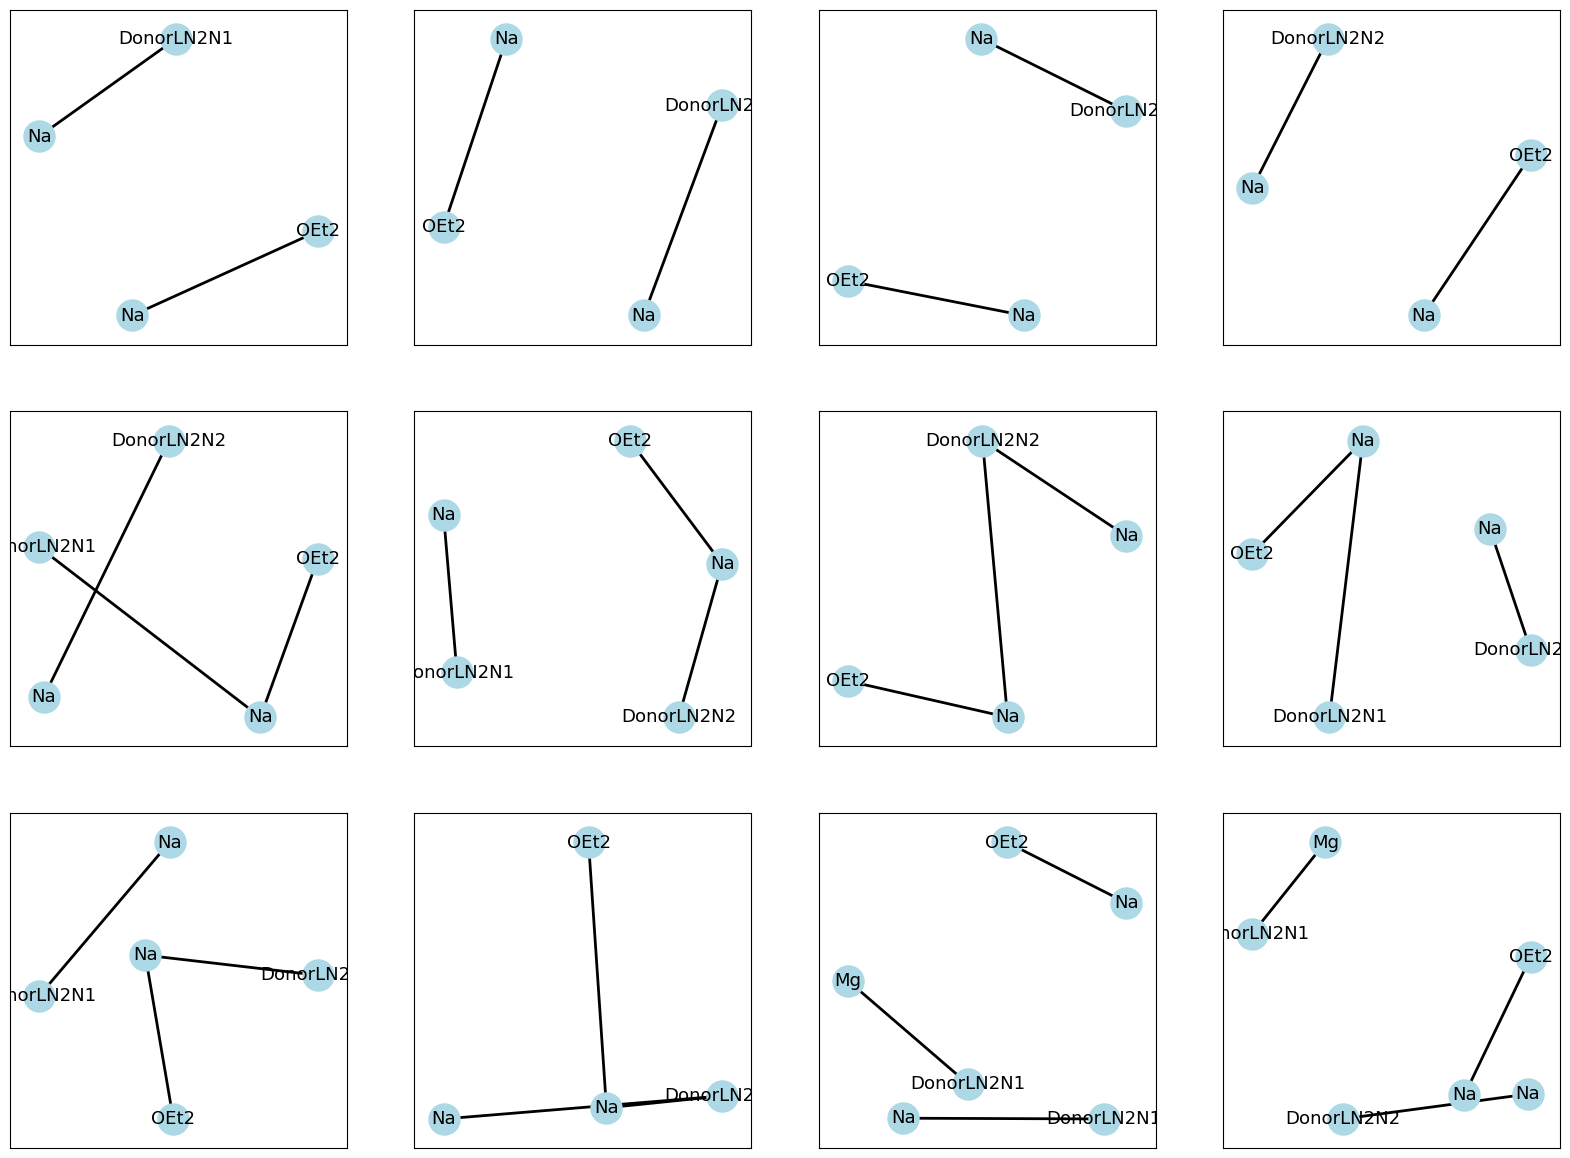

[PID 45961] Finished length 2 with 66 combinations
[PID 45961] Length 7 done with 11440 combinations
[PID 45961] Length 8 done with 12870 combinations
[PID 45961] Length 7 done with 11440 combinations
[PID 45963] Length 7 done with 11440 combinations
[PID 45963] Length 8 done with 12870 combinations
[PID 45964] Length 8 done with 12870 combinations
[PID 45964] Length 2 done with 120 combinations
[PID 45964] Length 5 done with 4368 combinations
[PID 45964] Length 8 done with 12870 combinations
[PID 45964] Length 1 done with 16 combinations
[PID 45964] Length 2 done with 120 combinations
[PID 45964] Length 3 done with 560 combinations
[PID 45964] Length 4 done with 1820 combinations
[PID 45964] Length 5 done with 4368 combinations
[PID 45964] Length 6 done with 8008 combinations
[PID 45964] Length 6 done with 8008 combinations
[PID 45959] Finished length 1 with 12 combinations
[PID 45959] Finished length 3 with 220 combinations
[PID 45959] Finished length 4 with 495 combinations
[PID 459

In [46]:
plot_graphs (filtered2_edges[0:12])

In [31]:
### this filters out the isomorphic graphs roughly before split nonconnected subgraphs


def compute_graph_hash(edges, node_labels):

    local_G = nx.Graph()
    local_G.add_nodes_from([(i, {"label": label}) for i, label in enumerate(node_labels)])
    local_G.add_edges_from(edges)
    
    # Compute and return the Weisfeiler-Lehman graph hash
    return nx.weisfeiler_lehman_graph_hash(local_G, node_attr='label')
# Assuming 'nodes' and 'filtered2_edges' are defined
node_labels = nodes

# Parallelize the computation of graph hashes
graphs_hashes = Parallel(n_jobs=num_cores)(delayed(compute_graph_hash)(edges, node_labels) for edges in filtered2_edges)

# Sequential part: filtering unique graphs based on hashes
filtered5_edges = []
filtered5_graphs = []
for i, graph_hash in enumerate(graphs_hashes):
    if graph_hash not in filtered5_graphs:
        filtered5_edges.append(filtered2_edges[i])
        filtered5_graphs.append(graph_hash)

print(len(filtered5_edges))

12


In [32]:
plot_graphs (filtered5_edges[3000:3001])

<Figure size 2000x2000 with 0 Axes>

In [33]:
### this filters and splits the unconnected graphs into sub graphs, keeping the one with the max connectivity

filtered3_edges = copy.copy(filtered5_edges)

for i in range(0, len(filtered5_edges)):
    Edges = list(G.edges)
    #print(i)
    G.remove_edges_from(Edges)
    to_remove = []
    for edge in filtered5_edges[i]:            
        G.add_edge(edge[0],edge[1])

    if donor_as_bridgeing: 
        #print('additional filter for bridging multidentate ligand turned on')
        Nodees = list(G.nodes)             ####here we add the temperory edges of the donors to ensure they are not filtered out
        temp_donor = []
        for n in Nodees:
            if 'Donor' in nodes[n]:
                temp_donor.append(n)            
        for c in range(monomers):
            #print (c)
            start = c * ((len(nodes))//monomers)
            end = start + ((len(nodes))//monomers)
            current_range = range(start, end)
            matching = [t for t in temp_donor if t in current_range]
            if len(matching) > 1:
                #print ('number of nodes', len(matching))
                unique_pairs = list(itertools.combinations(matching, 2))
                #print ('unique_pairs', unique_pairs)
                for pair in unique_pairs:
                    G.add_edge(pair[0],pair[1])
                    to_remove.append((pair[0],pair[1]))
                    #print ('to-remove', to_remove)"""
                
    if nx.is_connected(G)!=True:
        component=list(max(nx.connected_components(G)))
        for N in list(G.nodes):
            if N not in component:
                G.remove_node(N)
        #print(list(G.edges))
        if to_remove != []:
            G.remove_edges_from(to_remove)
        edgee = list(G.edges)
        nodee = list(G.nodes)
        #print(edgee)
        filtered3_edges[i] = edgee


filtered4_edges = []

for edge in filtered3_edges:
    #print (edge)
    #print ('checking')
    if edge not in filtered4_edges:
        if len(edge) != 0:
            #print ('yes edge included')
            filtered4_edges.append(edge)
            #print (filtered4_edges)
print (len(filtered4_edges))

12


In [34]:
plot_graphs (filtered4_edges[1000:1020])

<Figure size 2000x2000 with 0 Axes>

In [35]:
### this filters out the isomorphic graphs again
graphs = []
filtered7_edges = []
filtered7_graphs = []

        
G = nx.Graph(label="x")
for i in range(0, len(nodes)):
    #print(i)
    
    G.add_nodes_from([
        (i, {"label": nodes[i]}),
        ])


for i in range(0, len(filtered4_edges)):
    Edges = list(G.edges)
    G.remove_edges_from(Edges)
    
    for edge in filtered4_edges[i]:            
        G.add_edge(edge[0],edge[1])

    
    graphs.append(nx.weisfeiler_lehman_graph_hash(G, node_attr='label'))



for i in range(0, len(graphs)):
    if graphs[i] not in filtered7_graphs:
        filtered7_edges.append(filtered4_edges[i])
        filtered7_graphs.append(graphs[i])

print (len(filtered7_edges))

12


In [36]:
plot_graphs(filtered7_edges[160:165])

<Figure size 2000x2000 with 0 Axes>

In [37]:
### this filters any graphs that are charged again after split is needed
filtered8_edges = []

if Donorligand_charged == True:

    for i in range(0, len(filtered7_edges)):
        Edges = list(G.edges)
        G.clear()
        G.remove_edges_from(Edges)
        for edge in filtered7_edges[i]:            
            G.add_edge(edge[0],edge[1])
    
        #print(list(G.nodes))

        Donornodes = []
        Donor_charges = 0
        charge = 0
        for node in list(G.nodes):
            if 'Donor' in nodes[node]:
                #print ('yes')
                Donornodes.append(node)
            else: 
                charge = charge + charges[node]
                #print ('non donor charges')
                #print (charge)
                
        for c in range(monomers):
            start = c * ((len(nodes))//monomers)
            end = start + ((len(nodes))//monomers)
            current_range = range(start, end)
            #print (current_range)
            if any(d in current_range for d in Donornodes):
                Donor_charges += donor_total_charge
                #print ('yes', donor_total_charge )
                continue
        #print ('total donor charge:')
        #print (Donor_charges)
        charge = charge + Donor_charges
        #print ('total donor charge:')
        #print (Donor_charges)
        if charge == charge_specificed:
            filtered8_edges.append(filtered7_edges[i])
            #print ('total charge = 0')
    
    print('donor charge filter')
    print(len(filtered8_edges))
else:
    print('no donor charge filter')
    for i in range(0, len(filtered7_edges)):
        Edges = list(G.edges)
        G.clear()
        G.remove_edges_from(Edges)
        for edge in filtered7_edges[i]:            
            G.add_edge(edge[0],edge[1])
        charge = 0
    
        #print(list(G.nodes))

    
        for node in list(G.nodes):
            charge = charge + charges[node]
            #print (node, charges[node])
        #print (charge)
        if charge == charge_specificed:
            filtered8_edges.append(filtered7_edges[i])
            #print ('yes')
    print(len(filtered8_edges))
complete_filtered_edges = filtered8_edges

no donor charge filter
12


In [38]:
### filter user specificed controll of atom nums:

filtered9_edges = []
filtered_edges = copy.copy(filtered8_edges)

if user_specified_atomcount_controll:
    print ('now filter according to user defined atom_num')
    for i in range(0, len(filtered8_edges)):
        Edges = list(G.edges)
        G.clear()
        G.remove_edges_from(Edges)
        for edge in filtered8_edges[i]:            
            G.add_edge(edge[0],edge[1])
        charge = 0
    
        #print(list(G.nodes))

        for atom, num in user_specified_atomcount_controll:
            count = 0
            for node in list(G.nodes):
                if nodes[node] == atom:
                    count+=1
            if count != num:
                filtered_edges[i] = 'tbr'
                break

    for edges in filtered_edges:
        #print (edges)
        if edges != 'tbr':
            filtered9_edges.append(edges)
            #print (filtered6_nodonor_combinations)
        
    complete_filtered_edges = filtered9_edges
print (len(complete_filtered_edges))
#print (filteredcomplete_nodonor_combinations)


12


In [39]:
### additional trouble shooting function that allow you to check if a certain combination of edge is present in the filtered graphs

normalize = lambda e: tuple(sorted(e))
target_pairs = {normalize(e) for e in [(0,2), (0,3), (0,4), (5,7), (5,8), (5,9), (0,9), (5,4)]}

# Search for target set in valid combinations and get index
for i, combo in enumerate(complete_filtered_edges):  # or 'edges' if that's your list
    normalized_combo = {normalize(e) for e in combo}
    if target_pairs.issubset(normalized_combo):
        print("✅ Found matching combination!")
        print(f"   ➤ Index in list: {i}")
        print(f"   ➤ Combo edges: {combo}")
        # plot_graphs([combo])
        break
else:
    print("❌ No matching combination found.")


❌ No matching combination found.


In [40]:
plot_graphs(complete_filtered_edges[140:145])


<Figure size 2000x2000 with 0 Axes>

In [41]:
### constructure all filtered combintaion of all edges into graphs

GRAPHS = []

G = nx.Graph(label="x")

for i in range(len(complete_filtered_edges)):
    G.clear()
    
    for edge in complete_filtered_edges[i]:
        G.add_edge(edge[0],edge[1])
        
    for node in list(G.nodes):
        G.add_nodes_from([
            (node, {'label': nodes[node]}),
            ])
    
    Gtemp = G.copy()
    GRAPHS.append(Gtemp)
print(len(GRAPHS))

12


In [42]:
#**********************************************creating the 2D connection table**********************************#

In [44]:
### function to get the num of atoms in ct


def get_atoms_num(filename):
    with open (filename + '.ct', 'r') as f:
        lines = f.readlines()
        someinfo = lines[1].split()[0]
        return someinfo 

In [45]:
### function to get the atoms and coordinates connections in ct, returns a list of lists, each list = [x, y, atom type]


def get_coords(filename):
    with open (filename + '.ct', 'r') as f:
        lines = f.readlines()
        atoms_num = int(lines[1].split()[0])
        coords = []
        coord = []
        for line in lines[2 : 2 + atoms_num]:
            x = line.split()
            coo = [x[0], x[1], x[3]]
            coords.append(coo)
    return coords

In [46]:
### function to get the connectivities in ct, returns a list of lists, each list = [atom1, atom2, bond type, bond type]


def get_connect(filename):
    with open (filename + '.ct', 'r') as f:
        lines = f.readlines()
        atoms_num = int(lines[1].split()[0])
        connect_num = int(lines[1].split()[1])
        connect = []

        for line in lines[2 + atoms_num : 2 + atoms_num + connect_num ]:
            x = line.split()
            coo = [x[0], x[1], x[2], x[3]]
            connect.append(coo)
    return (connect)


In [47]:
###function to get the num of connections in ct 


def get_connect_num(filename):
    with open (filename + '.ct', 'r') as f:
        lines = f.readlines()
        someinfo = lines[1].split()[1]
        return someinfo 

In [48]:
### converting all graphs into 2D connection tables including all atoms and predefined bonds


i=0

for G in GRAPHS:

    open('speciation' + str(i) + '.ct', '+a').write('speciation' + str(i) + '.ct\n' + '0 0')
    connects = []
    
    for node in sorted(list(G.nodes)):
        #print(node)
        if 'Donor' not in nodes[node]:
            filename = nodes[node]
            #print (filename)
        elif 'Donor' in nodes[node]:
            filename = nodes[node]
            #print (filename)
            if int(filename[-1]) == 1:
                #print ('nod1')
                filename = nodes[node].replace('Donor', '')[:-2]

            elif int(filename[-1]) == 2:
                filename = nodes[node].replace('Donor', '')[:-2]
                #print (filename)
                #print (node, str(int(node)-1))
                if int(node)-1 in list(G.nodes):
                    with open('speciation' + str(i) + '.ct', 'r') as f:
                        lines = f.read()
                        lines = lines.replace('Nod2', str(node))
                        #print (lines)
                    with open('speciation' + str(i) + '.ct', 'w') as f:    
                        f.write(lines)
                        #print('skip')
                    continue
                
            elif int(filename[-1]) == 3:
                filename = nodes[node].replace('Donor', '')[:-2]
                #print (node, str(int(node)-1), str(int(node)-3))
                #print (filename)
                if int(node)-1 in list(G.nodes) or int(node)-2 in list(G.nodes):
                    with open('speciation' + str(i) + '.ct', 'r') as f:
                        lines = f.read()
                        lines = lines.replace('Nod3', str(node))
                        #print (lines)
                    with open('speciation' + str(i) + '.ct', 'w') as f:
                        f.write(lines)
                        #print('skip')
                    continue
        #print (filename)
        old_atom_num = int(get_atoms_num('speciation' + str(i)))      ######
        new_atom_num = int(get_atoms_num(filename)) + old_atom_num    ######
        old_atom_connect = int(get_connect_num('speciation' + str(i)))######
        new_atom_connect = int(get_connect_num(filename)) + old_atom_connect   ######

        with open('speciation' + str(i) + '.ct', 'r') as f:           ######
            lines = f.readlines()                                     ######
            lines[1] = str(new_atom_num) + ' ' + str(new_atom_connect) +'\n'   ###### update total number of atom and bonds
        with open('speciation' + str(i) + '.ct', 'w') as f:           ######
            f.writelines(lines)                                       ######
            coords = get_coords(filename)                             ######
            for coord in coords:                                      ######
                coord[0] = str(float(coord[0]) + 10 * node)           ###### writing the new atoms from the node to the file
                coord = [coo.replace('Node', str(node)) for coo in coord]       ###### replacing the donor atom with node number per each cycle
                #print (coord)
                if 'Donor' in nodes[node]:
                    temp = nodes[node]
                    if int(temp[-1]) == 1:
                        coord = [coo.replace('Nod1', str(node)) for coo in coord] 
                    elif int(temp[-1]) == 2:
                        coord = [coo.replace('Nod2', str(node)) for coo in coord]
                    elif int(temp[-1]) == 3:
                        coord = [coo.replace('Nod3', str(node)) for coo in coord]
                f.writelines(coord[0] + '    ' + coord[1] + '     ' + '0.00000' + '     ' + coord[2] +'\n') ######
            ligand_connections = get_connect(filename)                ######

        CONNCT = []                                                   ###### now get all the connections and store them in connects
        for ligand_connection in ligand_connections:                  ######
            atom1 = int(ligand_connection[0]) + int(old_atom_num)     ######
            atom2 = int(ligand_connection[1]) + int(old_atom_num)     ######
            bonda = ligand_connection[2]                              ######
            bondb = ligand_connection[3]                              ######
            CONNCT = [atom1, atom2, bonda, bondb]                     ######
            connects.append(CONNCT)                                   ######
    
    with open('speciation' + str(i) + '.ct', 'r') as f: 
        lines = f.read()
        for line in lines:
            #match = re.search(r'Nod(\d)', lines)
            updated_lines = re.sub(
                r'Nod(\d)', 
                lambda m: donor_nodx_atoms[int(m.group(1)) - 1],  # Adjust index if needed
                lines
            )
            #if match:
            #    digit = match.group(1)
            #    print (digit)
            #    lines = re.sub(r'Nod(\d)', donor_atoms[int(digit)+1], lines)
            #    print(lines)
    
    with open('speciation' + str(i) + '.ct', 'w') as f:    
        f.write(updated_lines)    
        #print(updated_lines)
        
    for connect in connects:                                           ######
        try:                                                           ######
            open('speciation' + str(i) + '.ct', '+a').write(str(connect[0]) + ' ' + str(connect[1]) + '  ' + str(connect[2]) + '  ' + str(connect[3]) + '\n')
        except:                                                        ######
            pass                                                       ######

    i = i + 1
    #print (i)

    print (new_atom_num)

    
#open('speciation' + str(i) + '.ct', '+a').write('speciation' + str(i) + '.ct\n' + '0 0')        
#open('speciation' + str(i) + '.ct', '+a').write(line)        
#open('speciation' + str(i) + '.ct', '+a').write(line)

85
114
128
142
143
157
171
171
157
171
171
171


In [49]:
### add the newly generated bonds from the graphs to the generated connection tables
### important please remove old .ct and start fresh run do not run the code twice it will break

i=0

for G in GRAPHS:
    # and now translating the edges to bonds and write the connection to ct
    with open('speciation' + str(i) + '.ct', 'r') as f:
        lines = f.readlines()
        connects = []
        for edge in sorted(list(G.edges)):
            #print(edge)
            connect = []
            atom_num_stop_point = int(get_atoms_num('speciation' + str(i)))+2
            for line in lines[2:atom_num_stop_point]:
                Coords = line.split()
                #print(line)
                #print(Coords[3])
               
                if str(Coords[3]) == str(edge[0]):
                    atom1 = lines.index(line)-1
                    connect.append(atom1)
                    #print('yes', atom1)
                
                if str(Coords[3]) == str(edge[1]):
                    atom2 = lines.index(line)-1
                    connect.append(atom2)
                    #print('yes', atom2)
                #print(connect)
            connects.append(connect) #connects for all edges in a graph
            #print(connects)
  
        for connect in connects:
            open('speciation' + str(i) + '.ct', '+a').write(str(connect[0]) + ' ' + str(connect[1]) + '  1  1\n')
            #print (connect)
            
        
        with open('speciation' + str(i) + '.ct', 'r') as f: 
            lines = f.readlines()
            lines[1] = str(get_atoms_num('speciation' + str(i))) + ' ' + str(int(get_connect_num('speciation' + str(i)))+len(connects)) +'\n'
        with open('speciation' + str(i) + '.ct', 'w') as f: 
            f.writelines(lines)
    print(i)
                
    i = i+1
    #print(i)

    

0
1
2
3
4
5
6
7
8
9
10
11


In [50]:
### now change the node label back to the correct elemental lable


i=0

for G in GRAPHS:    
    for node in sorted(list(G.nodes)):
        atom_type = donor_atoms[node]
        
        with open('speciation' + str(i) + '.ct', 'r') as f:
            lines = f.readlines()
            
            for line in lines [2:int(get_atoms_num('speciation' + str(i)))+2]:
                Coords = line.split()
                if str(Coords[3]) == str(node):
                    #print('yes')
                    lines[lines.index(line)] = coord[0] + '    ' + coord[1] + '     ' + '0.00000' + '     ' + donor_atoms[node] +'\n'
        
        with open('speciation' + str(i) + '.ct', 'w') as f: 
            f.writelines(lines)

    i = i+1

In [51]:
print (len(GRAPHS))

12


In [47]:
#************************************************* 3D xyz structures ****************************************************

In [55]:
### 2D to 3D embedding using openbabel, with additional filters


non_H_short_bonds = []
all_atom_short_bonds = []
malformed_xyz_files = []

def is_valid_xyz(filename):
    """
    Check if the XYZ file contains valid float coordinates in the expected format.
    Also ensures no NaN values are present.
    Returns True if valid, False otherwise.
    """
    try:
        with open(filename, 'r') as f:
            lines = f.readlines()

        assert len(lines) >= 3  # Must have header + at least 1 atom line

        for line in lines[2:]:
            parts = line.split()
            if len(parts) < 4:
                return False

            x = float(parts[1])
            y = float(parts[2])
            z = float(parts[3])

            # Check for NaN values
            if any(math.isnan(coord) for coord in (x, y, z)):
                return False

        return True

    except Exception:
        return False
        

def parse_xyz(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()[2:]
    atoms = []
    coords = []
    for line in lines:
        parts = line.split()
        atoms.append(parts[0])
        coords.append([float(x) for x in parts[1:4]])
    return atoms, np.array(coords)

def passes_non_H_threshold(atoms, coords, threshold=1.6): ### change here if needed
    for i in range(len(atoms)):
        if atoms[i] not in center:
            continue
        for j in range(i + 1, len(atoms)):
            if atoms[j] == 'H':
                continue
            distance = np.linalg.norm(coords[i] - coords[j])
            if distance <= threshold:
                return False
    return True

def passes_all_thresholds(atoms, coords, non_H_threshold=1.6, all_atom_threshold=0.9): ## change here if needed
    for i in range(len(atoms)):
        for j in range(i + 1, len(atoms)):
            distance = np.linalg.norm(coords[i] - coords[j])
            if distance <= all_atom_threshold:
                return False
            if atoms[i] in center and atoms[j] != 'H' and distance <= non_H_threshold:
                return False
    return True

def regenerate_structure(index):
    inputfile = f"speciation{index}.ct"
    outputfile = f"speciation{index}.xyz"
    final_atoms, final_coords = None, None

    # First tier: up to 50 attempts for non-H > 1.6 Å
    for attempt in range(1, 51):
        os.system(f"obabel {inputfile} -O {outputfile} --gen3d --best > /dev/null 2>&1")
        
        if not is_valid_xyz(outputfile):
            #malformed_xyz_files.append((index, attempt))
            #print(f"[WARNING] Malformed .xyz file at attempt {attempt} for index {index}. Skipping.")
            non_H_short_bonds.append(index)
            return [f"{index}: Failed non-H distance check (<1.6 Å) after 50 attempts. Saved last geometry."]

        atoms, coords = parse_xyz(outputfile)
        final_atoms, final_coords = atoms, coords

        if passes_non_H_threshold(atoms, coords):
            break
    else:
        non_H_short_bonds.append(index)
        return [f"{index}: Failed non-H distance check (<1.6 Å) after 50 attempts. Saved last geometry."]

    # Second tier: up to 200 attempts for all atoms > 0.9 Å and non-H > 1.6 Å
    for attempt in range(51, 201):
        if passes_all_thresholds(final_atoms, final_coords):
            return [f"{index}: Valid geometry found after {attempt} attempts."]
        os.system(f"obabel {inputfile} -O {outputfile} --gen3d --best > /dev/null 2>&1")

        if not is_valid_xyz(outputfile):
            malformed_xyz_files.append((index, attempt))
            print(f"[WARNING] Malformed .xyz file at attempt {attempt} for index {index}. Skipping.")
            continue

        final_atoms, final_coords = parse_xyz(outputfile)

    if not passes_all_thresholds(final_atoms, final_coords):
        all_atom_short_bonds.append(index)
        return [f"{index}: Failed all-atom distance check (<0.9 Å or non-H <1.6 Å) after 200 attempts. Saved last geometry."]
    else:
        return [f"{index}: Valid geometry found within 200 attempts."]

# Run in parallel
results = Parallel(n_jobs=num_cores)(delayed(regenerate_structure)(i) for i in range(len(GRAPHS)))


In [56]:
### save all the results into a logfile

# Append geometry validation results to logfile.rtf
with open('logfile.rtf', "a") as f:
    for log in results:
        for line in log:
            print(line)
            f.write(line + "\n")

# Detect indices that failed the all-atom threshold
check_needed = []

with open('logfile.rtf', "r") as f:
    for line in f:
        if "Failed all-atom distance check" in line:
            try:
                index = int(line.split(":")[0].strip())
                check_needed.append(index)
            except ValueError:
                continue  # Ignore malformed lines

# Append the "check_needed" indices to the log
with open("logfile.rtf", "a") as f:
    f.write("Entries that need checking: " + ", ".join(map(str, check_needed)) + "\n")

# NEW: Append malformed .xyz entries to the log
with open("logfile.rtf", "a") as f:
    f.write("\nMalformed .xyz files encountered:\n")
    for idx, attempt in malformed_xyz_files:
        log_entry = f" - Index {idx}, attempt {attempt}"
        print(log_entry)
        f.write(log_entry + "\n")

0: Valid geometry found after 51 attempts.
1: Valid geometry found after 51 attempts.
2: Valid geometry found after 51 attempts.
3: Valid geometry found after 51 attempts.
4: Valid geometry found after 51 attempts.
5: Failed all-atom distance check (<0.9 Å or non-H <1.6 Å) after 200 attempts. Saved last geometry.
6: Failed all-atom distance check (<0.9 Å or non-H <1.6 Å) after 200 attempts. Saved last geometry.
7: Failed all-atom distance check (<0.9 Å or non-H <1.6 Å) after 200 attempts. Saved last geometry.
8: Failed all-atom distance check (<0.9 Å or non-H <1.6 Å) after 200 attempts. Saved last geometry.
9: Valid geometry found after 51 attempts.
10: Failed all-atom distance check (<0.9 Å or non-H <1.6 Å) after 200 attempts. Saved last geometry.
11: Failed all-atom distance check (<0.9 Å or non-H <1.6 Å) after 200 attempts. Saved last geometry.


In [ ]:
### check the fails due to H-H short distances which could be easily fixed 

logfile_path = "logfile.rtf"
failed_indices = []

#Read logfile and extract failed indices
with open(logfile_path, "r") as f:
    for line in f:
        if "Failed non-H distance check (<1.6 Å) after 50 attempts. Saved last geometry." in line:
            try:
                index = int(line.split(":")[0].strip())
                failed_indices.append(index)
            except ValueError:
                continue  # skip malformed lines

#Rename the corresponding .xyz files
for index in failed_indices:
    original_name = f"speciation{index}.xyz"
    new_name = f"speciation{index}_nonH_failed.xyz"

    if os.path.exists(original_name):
        os.rename(original_name, new_name)
        print(f"Renamed {original_name} → {new_name}")
    else:
        print(f"[WARNING] File not found: {original_name}")

In [ ]:
### additional functions to fix the incorrectly place H atoms, if the H-H distances are too short
### fix all the files with H-H distance issue until all are fixed


num_cores = joblib.cpu_count()
print(num_cores)

def passes_HH_thresholds(atoms, coords, HH_threshold=0.9):
    close_pairs = []

    for i in range(len(atoms)):
        if atoms[i] != 'H':
            continue
        for j in range(i + 1, len(atoms)):
            if atoms[j] != 'H':
                continue
            distance = np.linalg.norm(coords[i] - coords[j])
            if distance <= HH_threshold:
                close_pairs.append((i, j))

    if close_pairs:
        print(close_pairs)
        return False, close_pairs
    else:
        return True, []


def find_nearest_carbon(atoms, coords, h_index):
    """Find the index of the carbon atom nearest to the specified hydrogen atom."""
    h_coord = coords[h_index]
    min_dist = float('inf')
    nearest_c_index = None

    for i, atom in enumerate(atoms):
        if atom == 'C':
            dist = np.linalg.norm(h_coord - coords[i])
            if dist < min_dist:
                min_dist = dist
                nearest_c_index = i
    return nearest_c_index


def rotation_matrix_around_axis(axis, theta):
    """Return rotation matrix for rotation about given axis by angle theta (radians)."""
    axis = axis / np.linalg.norm(axis)
    a = np.cos(theta / 2)
    b, c, d = -axis * np.sin(theta / 2)
    return np.array([
        [a*a + b*b - c*c - d*d,     2*(b*c - a*d),     2*(b*d + a*c)],
        [2*(b*c + a*d),     a*a + c*c - b*b - d*d,     2*(c*d - a*b)],
        [2*(b*d - a*c),     2*(c*d + a*b),     a*a + d*d - b*b - c*c]
    ])

def rotate_away(atoms, coords, h1_idx, h2_idx, c_idx, threshold=0.7):
    """
    Rotate H1 and H2 in the H1–C–H2 plane away from each other,
    keeping the bond lengths fixed and moving only in-plane.
    """
    h1 = coords[h1_idx]
    h2 = coords[h2_idx]
    c = coords[c_idx]

    vec_h1 = h1 - c
    vec_h2 = h2 - c

    # Define axis perpendicular to H1–C–H2 plane
    axis = np.cross(vec_h1, vec_h2)
    if np.linalg.norm(axis) == 0:
        print('⚠️ Colinear — generating fallback axis in i–C–(0,0,0) plane')
        fallback_axis = np.cross(vec_h1, np.array([0.0, 0.0, 1.0]))
        if np.linalg.norm(fallback_axis) == 0:
            fallback_axis = np.cross(vec_h1, np.array([1.0, 0.0, 0.0]))
        axis = fallback_axis / np.linalg.norm(fallback_axis)
    else:
        axis = axis / np.linalg.norm(axis)

    angle_step = np.deg2rad(5)

    # Initial vectors
    current_vec_h1 = vec_h1.copy()
    current_vec_h2 = vec_h2.copy()

    rot_pos = rotation_matrix_around_axis(axis, +angle_step)
    rot_neg = rotation_matrix_around_axis(axis, -angle_step)

    for _ in range(36):  # up to 180 degrees (5° steps)
        current_vec_h1 = np.dot(rot_pos, current_vec_h1)
        current_vec_h2 = np.dot(rot_neg, current_vec_h2)
        new_h1 = c + current_vec_h1
        new_h2 = c + current_vec_h2
        dist = np.linalg.norm(new_h1 - new_h2)
        #print(f"H–H distance: {dist:.4f}")
        if dist > threshold:
            new_coords = coords.copy()
            new_coords[h1_idx] = new_h1
            new_coords[h2_idx] = new_h2
            print('✅ Fixed via rotation')
            return new_coords

    print('❌ Rotation failed to separate Hs')
    return coords  # fallback if no fix



def log(msg, logfile="logfile.rtf"):
    print(msg)
    with open(logfile, "a") as f:
        f.write(msg + "\n")



"""running now the correction for H-H error in 3D"""


remaining = check_needed.copy()
max_loops = 10
loop_count = 0

while remaining and loop_count < max_loops:
    log(f"\n🔁 Iteration {loop_count + 1}, remaining: {remaining}\n")
    next_remaining = []

    for spec in remaining:
        xyz_file = f"speciation{spec}.xyz"
        output_file = xyz_file

        if not os.path.exists(xyz_file):
            log(f"❌ File not found: {xyz_file}")
            continue

        atoms, coords = parse_xyz(xyz_file)
        passed, pairs = passes_HH_thresholds(atoms, coords)

        if not passed:
            for i, j in pairs:
                c_index = find_nearest_carbon(atoms, coords, i)
                new_coords = rotate_away(atoms, coords, i, j, c_index)
                coords = new_coords

            with open(output_file, "w") as f:
                f.write(f"{len(atoms)}\n")
                f.write(f"Fixed geometry for {xyz_file}\n")
                for atom, coord in zip(atoms, coords):
                    f.write(f"{atom} {coord[0]:.5f} {coord[1]:.5f} {coord[2]:.5f}\n")

            log(f"🔧 Fixed and overwrote: {xyz_file}")
            next_remaining.append(spec)
        else:
            log(f"✅ {xyz_file} passed HH threshold check.")

    remaining = next_remaining
    loop_count += 1

if remaining:
    log(f"\n⚠️ Could not fix the following after {max_loops} attempts: {remaining}")
else:
    log("\n🎉 All files passed the HH threshold check!")

In [ ]:
#************************************************* energies and relaxation ****************************************************

In [ ]:
### function to count the total number of atoms


def get_atom_count(xyz_file_path):
    """
    Reads an XYZ file and returns the number of atoms.
    
    Parameters:
        xyz_file_path (str): Path to the .xyz file.
        
    Returns:
        int: Number of atoms in the file.
    """
    try:
        with open(xyz_file_path, 'r') as file:
            first_line = file.readline()
            atom_count = int(first_line.strip())
            return atom_count
    except (FileNotFoundError, ValueError, IndexError) as e:
        print(f"Error reading {xyz_file_path}: {e}")
        return None



In [ ]:
### get all the xyz files


import os

i = 0
num_atoms = []
files_found = 0  # Counter for successfully found files

for G in GRAPHS:
    filename = f"speciation{i}.xyz"

    if os.path.exists(filename):
        num_atoms.append(get_atom_count(filename))
        files_found += 1  # Increment counter
    else:
        num_atoms.append(0)
    
    i += 1

#print("Atom counts:", num_atoms)
print(f"Total number of files found: {files_found}")
#print(f"Total number of graphs processed: {len(GRAPHS)}")


In [ ]:
### remove the dummy atoms if the !!!!continue here to comment


if dummy_atom_needed != []:
    for i in range(len(GRAPHS)):
        filename = f"speciation{i}.xyz"

        if not os.path.exists(filename):
            print(f"[WARNING] File not found: {filename}. Skipping.")
            continue

        try:
            with open(filename, 'r') as f:
                lines = f.readlines()

            # Replace occurrences in each line
            updated_lines = [
                line.replace(dummy_atom_needed[1], dummy_atom_needed[0])
                for line in lines
            ]

            with open(filename, 'w') as f:
                f.writelines(updated_lines)

            print(f"[INFO] Updated file: {filename}")

        except Exception as e:
            print(f"[ERROR] Failed to process {filename}: {e}")

In [ ]:
##### uff ########

# Function to compute UFF energy
def compute_uff_energy(index, kj_to_kcal=1.0/4.184):
    filename = f"speciation{index}.xyz"

    if not os.path.exists(filename):
        print(f"[WARNING] File not found: {filename}. Setting UFF energy to 999999999.")
        return 999999999

    try:
        mol = next(pybel.readfile("xyz", filename))
        obmol = mol.OBMol

        ff = ob.OBForceField.FindForceField("uff")
        if not ff.Setup(obmol):
            print(f"[ERROR] UFF setup failed for molecule {index}. Setting UFF energy to 999999999.")
            return 999999999

        ff.SetCoordinates(obmol)
        uff_energy = ff.Energy(False) * kj_to_kcal  # False = no gradient calc
        return uff_energy

    except Exception as e:
        print(f"[EXCEPTION] Error processing {filename}: {e}. Setting UFF energy to 999999999.")
        return 999999999

# Run UFF energy calculation in parallel
num_molecules = len(GRAPHS)
num_cores = joblib.cpu_count()

E_gas_uff = Parallel(n_jobs=num_cores)(delayed(compute_uff_energy)(i) for i in range(num_molecules))

# Output results
for energy in E_gas_uff:
    print(energy)


In [ ]:
### saving the data, can rename the column name or file as wish

df = pd.DataFrame({'atom_num': num_atoms, 'E_gas_uff': E_gas_uff})
df.to_csv('E_gas-uff.csv')

In [ ]:
### sorting all data including the index of the xyz file, atom number and uff energy

import pandas as pd
from collections import defaultdict


input_file = "E_gas-uff.csv"
df = pd.read_csv(input_file)


atom_col = "atom_num"
energy_col = "E_gas_uff"

# Step 3: Organize data by atom number
atom_data = defaultdict(lambda: {"energy": [], "index": []})

for idx, row in df.iterrows():
    atom = int(row[atom_col])  # ensure integer atom_num
    energy = row[energy_col]
    atom_data[atom]["energy"].append(energy)
    atom_data[atom]["index"].append(idx)


pivot_data = {}
max_len = 0

for atom, data in atom_data.items():
    sorted_pairs = sorted(zip(data["energy"], data["index"]))
    sorted_energies, sorted_indices = zip(*sorted_pairs) if sorted_pairs else ([], [])
    
    pivot_data[f"{atom}_energy"] = list(sorted_energies)
    pivot_data[f"{atom}_index"] = list(map(int, sorted_indices))  # convert to int
    max_len = max(max_len, len(sorted_energies))

for key in pivot_data:
    padding = [None] * (max_len - len(pivot_data[key]))
    pivot_data[key].extend(padding)

output_df = pd.DataFrame(pivot_data)
output_file = "atom_energy_index_combined_output.csv"
output_df.to_csv(output_file, index=False)

print(f"Final output saved to: {output_file}")


In [ ]:
### reading the final sorted .csv and take the lowest energy structures evenly from each of the groups

totla_structure_num = 100 ### here define the total number of structures taken to be modelled, this should be > no. of group * 3 at least 

import pandas as pd

# Load the combined CSV
input_file = "atom_energy_index_combined_output.csv"
df = pd.read_csv(input_file)

# Initialize the list to hold index values
collected_indices = []

# Identify all columns that end with '_index'
index_columns = [col for col in df.columns if col.endswith("_index") and col != "0_index"]

# Iterate row by row
for _, row in df.iterrows():
    for col in index_columns:
        val = row[col]
        if pd.notna(val):
            collected_indices.append(int(val))
        if len(collected_indices) >= totla_structure_num:
            break
    if len(collected_indices) >= totla_structure_num:
        break

# Display the collected list of indices (first few entries shown as preview)
collected_indices[:10], len(collected_indices)

In [ ]:
######## costum creation of gaussian input files ##########
### the user should have experience in creating gaussian input files using the vi. 
### please modify the level of theory, and core mem setting occurdingly.


i=0
name = 'speciation'


for index in collected_indices:
    new_comfile = name + str(index) + '.com'
    open(new_comfile, '+a').write('%chk=' + name + str(index) + '.chk' + '\n' + '%nprocshared=16\n' + '%mem=32GB\n' + '#p opt=loose PM7 freq scf=xqc \n' + '\n speciation study\n' + '\n-1 1\n')
    print(str(index))
    
    with open("speciation" + str(index) + ".xyz", 'r') as f:
        lines = f.readlines()
    for line in lines:
        if lines.index(line) >= 2:
            open(new_comfile, '+a').write(line)
            
    open(new_comfile, '+a').write('\n')
    i = i + 1

"""atom_H = False
atom_Li = False
atom_K = False
atom_C = False
atom_N = False
atom_O = False
atom_F = False
atom_Si = False
atom_Co = False
atom_U = False
atom_Na = False
atom_Mg = False

#basis_Co = '-Co 0\nlanl2dz\nF 1 1.0\n2.780 1.0\n****\n'
basis_U = '-U 0\nlanl2dz\n****\n'
basis_K = '-K 0\nlanl2dz\n****\n'
basis_Li = '-Li 0\n6-31g(d,p)\n****\n'
#basis_K = '-K 0\n6-31g(d,p)\n****\n'
basis_Na = '-Na 0\n6-31g(d,p)\n****\n'
basis_Mg = '-Mg 0\n6-31g(d,p)\n****\n'
basis_H = '-H 0\n6-31g(d,p)\n****\n'
basis_C = '-C 0\n6-31g(d,p)\n****\n'
basis_N = '-N 0\n6-31+g(d,p)\n****\n'
basis_O = '-O 0\n6-31+g(d,p)\n****\n'
basis_F = '-F 0\n6-31+g(d,p)\n****\n'
basis_Si = '-Si 0\n6-31g(d,p)\n****\n'


i=0

for index in collected_indices:
    new_comfile = name + str(index) + '.com'
    with open(new_comfile, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if 'Mg    ' in line:
                atom_Mg = True    
            if atom_U:
                open(new_comfile, '+a').write(basis_Mg)
                break

        for line in lines:
            if 'H    ' in line:
                atom_H = True
            if atom_H:
                open(new_comfile, '+a').write(basis_H)
                break
                
        for line in lines:
            if 'K    ' in line:
                atom_K = True
            if atom_K:
                open(new_comfile, '+a').write(basis_K)
                break
                
        for line in lines:
            if 'Li    ' in line:
                atom_Li = True
            if atom_Li:
                open(new_comfile, '+a').write(basis_Li)
                break
                
        for line in lines:
            if 'Na    ' in line:
                atom_Na = True
            if atom_Na:
                open(new_comfile, '+a').write(basis_Na)
                break
    
        for line in lines:
            if 'C    ' in line:
                atom_C = True
            if atom_C:
                open(new_comfile, '+a').write(basis_C)
                break

        for line in lines:
            if 'N    ' in line:
                atom_N = True
            if atom_N:
                open(new_comfile, '+a').write(basis_N)
                break
    
        for line in lines:
            if 'O    ' in line:
                atom_O = True
            if atom_O:
                open(new_comfile, '+a').write(basis_O)
                break

        for line in lines:
            if 'F    ' in line:
                atom_F = True
            if atom_F:
                open(new_comfile, '+a').write(basis_F)
                break            
            
        for line in lines:
            if 'Si    ' in line:
                atom_Si = True
            if atom_Si:
                open(new_comfile, '+a').write(basis_Si)
                break            
            
            
        i=i+1    
        f.close()"""
open(new_comfile, '+a').write('\n\n')
    #open(new_comfile, '+a').write('\nU\nlanl2dz')
    #open(new_comfile, '+a').write('\nK\nlanl2dz\n\n')


In [ ]:
#************************************************* post Gaussian calculations ****************************************************

In [269]:
### automating getting the Gibbs energy from the .log files 

import os
import re
from collections import defaultdict

def extract_scf_energy_and_natoms(filepath):
    energy_pattern = re.compile(r'SCF Done:\s+E\(RPM7\)\s+=\s+([-+]?\d*\.\d+(?:[Ee][+-]?\d+)?)') ### here can be changed to get the E(Done) if desired
    natoms_pattern = re.compile(r'NAtoms=\s+(\d+)')
    
    last_energy = None
    last_natoms = None

    with open(filepath, 'r') as file:
        for line in file:
            energy_match = energy_pattern.search(line)
            if energy_match:
                last_energy = float(energy_match.group(1))
            natoms_match = natoms_pattern.search(line)
            if natoms_match:
                last_natoms = int(natoms_match.group(1))

    return last_energy, last_natoms


directory_path = "/Users/mantingmu/Desktop/CASE3_Mg2IIP/SSIP/anion2/PM7-log"  ### provide the actual path
grouped_results = defaultdict(list)

for filename in os.listdir(directory_path):
    if filename.endswith(".log"):
        cleaned_name = filename.replace("speciation", "")
        if cleaned_name.endswith("b.log"):
            cleaned_name = cleaned_name.replace("b.log", "").replace("b", "")
        elif cleaned_name.endswith(".log"):
            cleaned_name = cleaned_name.replace(".log", "")
        
        full_path = os.path.join(directory_path, filename)
        #print (full_path)
        energy, natoms = extract_scf_energy_and_natoms(full_path)

        if energy is not None and natoms is not None:
            grouped_results[natoms].append((cleaned_name, energy, natoms))

sorted_index = []

### Sort and display the lowest energy entries per natoms group (3 by default), which will subject to further modelling
structures_per_group = 3  ### change here if would like to sample more


for natoms in sorted(grouped_results.keys()):
    group = grouped_results[natoms]
    #print (group)
    sorted_group = sorted(group, key=lambda x: x[1])  # sort by energy

    print(f"\nTop 3 lowest SCF energies for NAtoms = {natoms}:")
    for entry in sorted_group[:structures_per_group]:  
        name, energy, _ = entry
        sorted_index.append(name)
        print(f"  {name.strip()}: {energy:.12f}")

output_dict = {}

for natoms in sorted(grouped_results.keys()):
    sorted_group = sorted(grouped_results[natoms], key=lambda x: x[1])
    indices = [str(entry[0]) for entry in sorted_group[:structures_per_group]]
    energies = [f"{entry[1]:.12f}" for entry in sorted_group[:structures_per_group]]

    # pad to 3 entries
    while len(indices) < structures_per_group:
        indices.append("")
        energies.append("")

    output_dict[f"{natoms}_index"] = indices
    output_dict[f"{natoms}_energy"] = energies

# Convert to DataFrame
df = pd.DataFrame(output_dict)

# Save to CSV
df.to_csv("top3_grouped_by_natoms.csv", index=False)

print("CSV saved as 'top3_grouped_by_natoms.csv'")


Top 3 lowest SCF energies for NAtoms = 51:
  157: 0.071538393761
  159: 0.082843258549
  158: 0.095981902244

Top 3 lowest SCF energies for NAtoms = 52:
  9: -0.012109387469
  10: -0.007612070896
  8: -0.005694945766

Top 3 lowest SCF energies for NAtoms = 66:
  2: -0.044670156287
  1: -0.042283180603
  4: -0.029273119784

Top 3 lowest SCF energies for NAtoms = 67:
  53: -0.111797072148
  52: -0.107770678265

Top 3 lowest SCF energies for NAtoms = 78:
  11: -0.063565906816
  39: -0.059670909588
  45: -0.057244099855

Top 3 lowest SCF energies for NAtoms = 81:
  5: -0.156555600440
  7: -0.143602822620
  6: -0.116108504657

Top 3 lowest SCF energies for NAtoms = 93:
  94: -0.230232534586
  66: -0.203950902300
  71: -0.203308599755

Top 3 lowest SCF energies for NAtoms = 108:
  131: -0.332532511151
  114: -0.302301952192
  133: -0.285816443893
CSV saved as 'top3_grouped_by_natoms.csv'


In [270]:
print(sorted_index) ### just to double check again

['157', '159', '158', '9', '10', '8', '2', '1', '4', '53', '52', '11', '39', '45', '5', '7', '6', '94', '66', '71', '131', '114', '133']


In [271]:
### taking atructures from .log files and write new .com files with higher level of theory


import os

# Predefined values
name = 'speciationDFT'

# atomic number to symbol mapping please add more as go
atomic_number_to_symbol = {
    1: 'H', 3: 'Li', 6: 'C', 7: 'N', 8: 'O', 9: 'F',
    11: 'Na', 12: 'Mg', 14: 'Si', 19: 'K', 27: 'Co'
}

# Basis set definitions
atom_basis = {
    'H': '-H 0\n6-31g(d,p)\n****\n',
    'Li': '-Li 0\n6-31g(d,p)\n****\n',
    'K': '-K 0\n6-31g(d,p)\n****\n',
    'Na': '-Na 0\n6-31g(d,p)\n****\n',
    'C': '-C 0\n6-31g(d,p)\n****\n',
    'N': '-N 0\n6-31+g(d,p)\n****\n',
    'O': '-O 0\n6-31+g(d,p)\n****\n',
    'F': '-F 0\n6-31+g(d,p)\n****\n',
    'Si': '-Si 0\n6-31g(d,p)\n****\n',
    'Mg': '-Mg 0\n6-31g(d,p)\n****\n',
    'Co': '-Co 0\nlanl2dz\nF 1 1.0\n2.780 1.0\n****\n'
}

def extract_last_geometry_from_log(full_path):
    with open(full_path, 'r') as f:
        lines = f.readlines()

    start_indices = [i for i, line in enumerate(lines) if 'Standard orientation:' in line]
    if not start_indices:
        return []

    geom_start = start_indices[-1] + 5
    geom = []

    for line in lines[geom_start:]:
        if '-----' in line or line.strip() == '':
            break
        parts = line.split()
        atom_num = int(parts[1])
        x, y, z = map(float, parts[3:6])
        element = atomic_number_to_symbol.get(atom_num, 'X')  # fallback to 'X'
        geom.append(f"{element} {x:.6f} {y:.6f} {z:.6f}")

    return geom

def find_log_file_with_fallback(directory_path, base_filename):
    """
    Try finding the .log file by appending up to four 'b's before the extension if needed.
    """
    for i in range(5):  # 0 to 4 b's
        b_suffix = 'b' * i
        filename = f"{base_filename}{b_suffix}.log"
        full_path = os.path.join(directory_path, filename)
        if os.path.exists(full_path):
            return full_path, filename
    return None, None

# Main loop
for index in sorted_index:
    base_filename = f"speciation{index}"
    full_path, filename = find_log_file_with_fallback(directory_path, base_filename)
    com_file = f"{name}{index}.com"

    if not full_path:
        print(f"❌ File not found: tried {base_filename}[b].log up to 4 bs")
        continue

    geometry_lines = extract_last_geometry_from_log(full_path)
    if not geometry_lines:
        print(f"⚠️  No geometry found in {filename}")
        continue

    with open(com_file, 'w') as f:
        f.write(f"%chk={name}{index}.chk\n")
        f.write("%nprocshared=32\n")
        f.write("%mem=64GB\n")
        f.write("#p opt=loose wb97xd/gen scf=xqc freq\n\n")
        f.write("speciation study\n\n")
        f.write("0 1\n")
        for line in geometry_lines:
            f.write(line + "\n")
        f.write("\n")

        atoms_present = set(line.split()[0] for line in geometry_lines)
        for atom in atoms_present:
            if atom in atom_basis:
                f.write(atom_basis[atom])

        f.write("\n\n")


In [66]:
### again creating the .csv with the results from calculations


import os
import re
from collections import defaultdict

def extract_scf_energy_and_natoms(filepath):
    energy_pattern = re.compile(r'SCF Done:\s+E\(\w+\)\s+=\s+([-+]?\d+\.\d+)\s+A\.U\.')
    natoms_pattern = re.compile(r'NAtoms=\s+(\d+)')
    
    last_energy = None
    last_natoms = None

    with open(filepath, 'r') as file:
        for line in file:
            energy_match = energy_pattern.search(line)
            if energy_match:
                last_energy = float(energy_match.group(1))
            natoms_match = natoms_pattern.search(line)
            if natoms_match:
                last_natoms = int(natoms_match.group(1))

    return last_energy, last_natoms


directory_path = "/Users/mantingmu/Desktop/CASE3_Mg2IIP/SSIP/anion2/dft/" ### modify
grouped_results = defaultdict(list)

for filename in os.listdir(directory_path):
    if filename.endswith(".log"):
        cleaned_name = filename.replace("speciationDFT", "")
        if cleaned_name.endswith("b.log"):
            cleaned_name = cleaned_name.replace("b.log", "").replace("b", "")
        elif cleaned_name.endswith(".log"):
            cleaned_name = cleaned_name.replace(".log", "")
        
        full_path = os.path.join(directory_path, filename)
        #print (full_path)
        energy, natoms = extract_scf_energy_and_natoms(full_path)

        if energy is not None and natoms is not None:
            grouped_results[natoms].append((cleaned_name, energy, natoms))

sorted_index = []

# Sort and display the top 3 lowest energy entries per natoms group
for natoms in sorted(grouped_results.keys()):
    group = grouped_results[natoms]
    #print (group)
    sorted_group = sorted(group, key=lambda x: x[1])  # sort by energy

    print(f"\nTop 3 lowest SCF energies for NAtoms = {natoms}:")
    for entry in sorted_group[:3]:
        name, energy, _ = entry
        sorted_index.append(name)
        print(f"  {name.strip()}: {energy:.12f}")

output_dict = {}

for natoms in sorted(grouped_results.keys()):
    sorted_group = sorted(grouped_results[natoms], key=lambda x: x[1])
    indices = [str(entry[0]) for entry in sorted_group[:3]]
    energies = [f"{entry[1]:.12f}" for entry in sorted_group[:3]]

    # pad to 3 entries
    while len(indices) < 3:
        indices.append("")
        energies.append("")

    output_dict[f"{natoms}_index"] = indices
    output_dict[f"{natoms}_energy"] = energies

# Convert to DataFrame
df = pd.DataFrame(output_dict)

# Save to CSV
df.to_csv("/Users/mantingmu/Desktop/CASE3_Mg2IIP/SSIP/anion2/DFT_Energies.csv", index=False) ### modify

print("CSV saved as 'DFT_Energies.csv'")


Top 3 lowest SCF energies for NAtoms = 51:
  158: -1121.656022750000
  159: -1121.628371480000
  157: -1121.612585170000

Top 3 lowest SCF energies for NAtoms = 52:
  10: -976.416216526000
  8: -976.414935449000
  9: -976.405817720000

Top 3 lowest SCF energies for NAtoms = 66:
  1: -1355.260822190000
  4: -1355.255722880000
  2: -1355.241847610000

Top 3 lowest SCF energies for NAtoms = 67:
  53: -1210.026331160000
  52: -1210.006163200000

Top 3 lowest SCF energies for NAtoms = 78:
  45: -1637.418838540000
  39: -1637.384808520000
  11: -1637.367230260000

Top 3 lowest SCF energies for NAtoms = 81:
  7: -1588.846866770000
  5: -1588.840283230000
  6: -1588.825210550000

Top 3 lowest SCF energies for NAtoms = 93:
  71: -1870.985984500000
  66: -1870.980613260000
  66: -1870.979919140000

Top 3 lowest SCF energies for NAtoms = 108:
  114: -2104.638933310000
  133: -2104.621864080000
  114: -2104.610933150000
CSV saved as 'DFT_Energies.csv'


In [ ]:
#************************************************* IIP structures ****************************************************

In [48]:
### here we will generat all the IIP structures
### note the SSIPs should be at least generated by SPECI, optimised with appropiate level of theory is recommanded prior to this


import os
import numpy as np
from ase import Atoms
from ase.io import read, write
from itertools import product
from copy import deepcopy
from collections import Counter
import tempfile
from openbabel import pybel, openbabel as ob
import contextlib
import io

kj_to_kcal = 0.239005736

######### Utility Functions #########

def find_closest_atoms(cation, anion):
    min_distance = np.inf
    idx_c, idx_a = -1, -1
    for i, atom_c in enumerate(cation):
        for j, atom_a in enumerate(anion):
            distance = np.linalg.norm(atom_a.position - atom_c.position)
            if distance < min_distance:
                min_distance = distance
                idx_c, idx_a = i, j
    return idx_c, idx_a

def adjust_positions(cation, anion, initial_distance, final_distance):
    com_cation = cation.get_center_of_mass()
    com_anion = anion.get_center_of_mass()
    initial_vector = com_anion - com_cation
    norm_initial_vector = initial_vector / np.linalg.norm(initial_vector)
    anion.translate(norm_initial_vector * (initial_distance - np.linalg.norm(initial_vector)))

    idx_c, idx_a = find_closest_atoms(cation, anion)
    atom_c = cation[idx_c].position
    atom_a = anion[idx_a].position
    vector = atom_a - atom_c
    norm_vector = vector / np.linalg.norm(vector)
    displacement = (final_distance - np.linalg.norm(atom_a - atom_c)) * norm_vector
    anion.translate(displacement)

######### UFF Optimized Placement Function #########

def random_placement_all(cation, anion, initial_distance=50.0, final_distance=2.5):
    structures_with_energies = []
    rotation_angles = [0, 120, 240]

    for cx in rotation_angles:
        for cy in rotation_angles:
            for cz in rotation_angles:
                temp_cation = cation.copy()
                temp_cation.rotate(cx, 'x', center='COM')
                temp_cation.rotate(cy, 'y', center='COM')
                temp_cation.rotate(cz, 'z', center='COM')

                for ax in rotation_angles:
                    for ay in rotation_angles:
                        for az in rotation_angles:
                            temp_anion = anion.copy()
                            temp_anion.rotate(ax, 'x', center='COM')
                            temp_anion.rotate(ay, 'y', center='COM')
                            temp_anion.rotate(az, 'z', center='COM')

                            adjusted_anion = temp_anion.copy()
                            adjust_positions(temp_cation, adjusted_anion, initial_distance, final_distance)

                            combined = temp_cation + adjusted_anion

                            try:
                                with tempfile.NamedTemporaryFile(delete=False, suffix=".xyz", mode='w') as tmp:
                                    tmp_name = tmp.name
                                    write(tmp, combined, format='xyz')

                                mol = next(pybel.readfile("xyz", tmp_name))
                                obmol = mol.OBMol
                                ff = ob.OBForceField.FindForceField("uff")

                                with contextlib.redirect_stderr(io.StringIO()):
                                    uff_ok = ff.Setup(obmol)

                                if not uff_ok:
                                    print("[ERROR] UFF setup failed. Skipping...")
                                    current_energy = 999999999
                                else:
                                    with contextlib.redirect_stderr(io.StringIO()):
                                        ff.SteepestDescent(50)
                                        ff.GetCoordinates(obmol)
                                        current_energy = ff.Energy(False) * kj_to_kcal
                                        mol.write("xyz", tmp_name, overwrite=True)

                                    try:
                                        combined_optimized = read(tmp_name)
                                        if len(combined_optimized) == 0:
                                            print("[WARNING] Optimized structure is empty. Using pre-optimized.")
                                            combined_optimized = combined
                                    except Exception as e:
                                        print(f"[WARNING] Reading optimized structure failed: {e}")
                                        combined_optimized = combined

                                    combined = combined_optimized

                                os.remove(tmp_name)

                            except Exception as e:
                                print(f"[EXCEPTION] UFF optimization failed: {e}")
                                current_energy = 999999999

                            structures_with_energies.append((combined.copy(), current_energy))

    return structures_with_energies

######### Redundant Filtering #########

def unique_multisets(elements, r):
    seen = set()
    for combo in product(elements, repeat=r):
        key = tuple(sorted(Counter(combo).items()))
        if key not in seen:
            seen.add(key)
            yield combo

######### Main Logic #########

def generate_combinations(base_dir, cation_count, anion_count):
    cat_dir = os.path.join(base_dir, 'cat')
    ani_dir = os.path.join(base_dir, 'ani')
    output_dir = os.path.join(base_dir, 'generated_xyz')
    os.makedirs(output_dir, exist_ok=True)

    cat_files = sorted([f for f in os.listdir(cat_dir) if f.endswith('.xyz')])
    ani_files = sorted([f for f in os.listdir(ani_dir) if f.endswith('.xyz')])

    if not cat_files or not ani_files:
        raise ValueError("No .xyz files found in 'cat/' or 'ani/'")

    cat_combos = list(unique_multisets(cat_files, cation_count))
    ani_combos = list(unique_multisets(ani_files, anion_count))

    output_index = 0

    for cat_group in cat_combos:
        print (cat_group)
        for ani_group in ani_combos:
            print (ani_group)
            cation0 = read(os.path.join(cat_dir, cat_group[0]))
            anion0 = read(os.path.join(ani_dir, ani_group[0]))
            initial_structures = random_placement_all(cation0, anion0)

            if cation_count > 1 or anion_count > 1:
                initial_structures = [min(initial_structures, key=lambda x: x[1])]

            all_final_structs = []

            for base_struct, base_energy in initial_structures:
                current_structs = [(base_struct, base_energy)]

                for i in range(1, anion_count):
                    next_anion = read(os.path.join(ani_dir, ani_group[i]))
                    new_structs = []
                    for struct, _ in current_structs:
                        added = random_placement_all(next_anion, struct)
                        new_structs.extend(added)

                    # Keep only most stable if more than 2 anions
                    if anion_count > 2:
                        current_structs = [min(new_structs, key=lambda x: x[1])]
                    else:
                        current_structs = new_structs

                for j in range(1, cation_count):
                    next_cation = read(os.path.join(cat_dir, cat_group[j]))
                    new_structs = []
                    for struct, _ in current_structs:
                        added = random_placement_all(next_cation, struct)
                        new_structs.extend(added)

                    # Keep only most stable if more than 2 cations
                    if cation_count > 2:
                        current_structs = [min(new_structs, key=lambda x: x[1])]
                    else:
                        current_structs = new_structs

                all_final_structs.extend(current_structs)

            sorted_finals = sorted(all_final_structs, key=lambda x: x[1])[:10]

            trace = "_".join([f.replace(".xyz", "").replace(" ", "") for f in (cat_group + ani_group)])
            for rank, (structure, energy) in enumerate(sorted_finals):
                filename = (
                    f"lowest10_c{cation_count}_a{anion_count}_"
                    f"{trace}_rank{rank+1:02d}_E{energy:.2f}.xyz"
                )
                full_path = os.path.join(output_dir, filename)
                write(full_path, structure, format='xyz')
            print ('output_index = ', output_index)
            output_index += 1

# === USAGE ===
### one should have in the base_dir a folder named "ani" and a foler named "cat", the ouput IIP xyzs will be in the "generated_xyz" folder
base_dir = '/Users/mantingmu/Desktop/CASE3_Mg2IIP/IIP/cat2ani2' ### please edit here 
generate_combinations(base_dir, cation_count=1, anion_count=1) ### modify the cation and anion _count here to specify the numbers


('speciation0.xyz',)
('speciationDFT11.xyz',)


*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is /var/folders/gj/r_f2w8bd64s567tc6v39_dbm0000gn/T/tmph5anqyp9.xyz)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is /var/folders/gj/r_f2w8bd64s567tc6v39_dbm0000gn/T/tmpqkc4a31w.xyz)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is /var/folders/gj/r_f2w8bd64s567tc6v39_dbm0000gn/T/tmp7y063s5s.xyz)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is /var/folders/gj/r_f2w8bd64s567tc6v39_dbm0000gn/T/tmpws0q26_6.xyz)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is /var/folders/gj/r_f2w8bd64s567tc6v39_dbm0000gn/T/tmp9f9e6yku.xyz)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to ke

output_index =  0
('speciationDFT133.xyz',)


*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is /var/folders/gj/r_f2w8bd64s567tc6v39_dbm0000gn/T/tmp4is3hnx3.xyz)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is /var/folders/gj/r_f2w8bd64s567tc6v39_dbm0000gn/T/tmpohfoovde.xyz)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is /var/folders/gj/r_f2w8bd64s567tc6v39_dbm0000gn/T/tmpdap1mhon.xyz)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is /var/folders/gj/r_f2w8bd64s567tc6v39_dbm0000gn/T/tmpwzuxqpb7.xyz)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is /var/folders/gj/r_f2w8bd64s567tc6v39_dbm0000gn/T/tmp4g6x9__b.xyz)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to ke

KeyboardInterrupt: 

In [9]:
output_path = os.path.join(base_dir, 'generated_xyz')
print(base_dir)

/Users/mantingmu/Desktop/CASE3_Mg2IIP/IIP/cat2ani2


In [10]:
### automated generation of gaussian input file 


import os
from collections import defaultdict

######### Configuration #########
xyz_dir = 'generated_xyz'
output_dir = 'gaussian_inputs'
os.makedirs(output_dir, exist_ok=True)

nproc = 20
mem = '40GB'
route_section = '#p opt=loose PM7/gen scf=xqc '

######### Basis Set Definitions #########
basis_sets = {
    'H':  '-H 0\n6-31g(d,p)\n****\n',
    'Li': '-Li 0\n6-31g(d,p)\n****\n',
    'K':  '-K 0\n6-31g(d,p)\n****\n',
    'Na': '-Na 0\n6-31g(d,p)\n****\n',
    'C':  '-C 0\n6-31g(d,p)\n****\n',
    'N':  '-N 0\n6-31+g(d,p)\n****\n',
    'O':  '-O 0\n6-31+g(d,p)\n****\n',
    'F':  '-F 0\n6-31+g(d,p)\n****\n',
    'Si': '-Si 0\n6-31g(d,p)\n****\n',
    'Mg': '-Mg 0\n6-31g(d,p)\n****\n',
    'Co': '-Co 0\nlanl2dz\nF 1 1.0\n2.780 1.0\n****\n'
}

######### Processing Each .xyz File #########
xyz_files = [f for f in os.listdir(output_path) if f.endswith('.xyz')]

if not xyz_files:
    raise RuntimeError(f"No .xyz files found in '{xyz_dir}'")

for xyz_file in sorted(xyz_files):
    xyz_path = os.path.join(output_path, xyz_file)
    base_name = os.path.splitext(xyz_file)[0]
    com_filename = base_name + '.com'
    com_path = os.path.join(output_path, com_filename)
    chk_name = base_name + '.chk'

    # Read XYZ geometry
    with open(xyz_path, 'r') as f:
        lines = f.readlines()
        atom_lines = lines[2:]  # skip first two header lines

    # Detect which atoms are present
    present_atoms = set()
    for line in atom_lines:
        parts = line.strip().split()
        if parts:
            atom = parts[0]
            if atom in basis_sets:
                present_atoms.add(atom)

    # Write Gaussian input (.com)
    with open(com_path, 'w') as com:
        # Header
        com.write(f'%chk={chk_name}\n')
        com.write(f'%nprocshared={nproc}\n')
        com.write(f'%mem={mem}\n')
        com.write(f'{route_section}\n\n')
        com.write(f'{base_name} DFT input\n\n')
        com.write('0 1\n')

        # Geometry
        for line in atom_lines:
            com.write(line)

        com.write('\n')

        # Basis Sets
        for atom in sorted(present_atoms):
            com.write(basis_sets[atom])

        com.write('\n\n')

    print(f"✅ Generated: {com_path}")


✅ Generated: /Users/mantingmu/Desktop/CASE3_Mg2IIP/IIP/cat2ani2/generated_xyz/lowest10_c1_a1_speciation0_speciationDFT11_rank01_E130.06.com
✅ Generated: /Users/mantingmu/Desktop/CASE3_Mg2IIP/IIP/cat2ani2/generated_xyz/lowest10_c1_a1_speciation0_speciationDFT11_rank02_E130.16.com
✅ Generated: /Users/mantingmu/Desktop/CASE3_Mg2IIP/IIP/cat2ani2/generated_xyz/lowest10_c1_a1_speciation0_speciationDFT11_rank03_E130.20.com
✅ Generated: /Users/mantingmu/Desktop/CASE3_Mg2IIP/IIP/cat2ani2/generated_xyz/lowest10_c1_a1_speciation0_speciationDFT11_rank04_E130.31.com
✅ Generated: /Users/mantingmu/Desktop/CASE3_Mg2IIP/IIP/cat2ani2/generated_xyz/lowest10_c1_a1_speciation0_speciationDFT11_rank05_E130.36.com
✅ Generated: /Users/mantingmu/Desktop/CASE3_Mg2IIP/IIP/cat2ani2/generated_xyz/lowest10_c1_a1_speciation0_speciationDFT11_rank06_E130.45.com
✅ Generated: /Users/mantingmu/Desktop/CASE3_Mg2IIP/IIP/cat2ani2/generated_xyz/lowest10_c1_a1_speciation0_speciationDFT11_rank07_E130.46.com
✅ Generated: /Users/

In [ ]:
#************************************************* preparing for COPASI calculation applies to CIP, SSIP and IIPs ****************************************************

In [114]:
### getting all the Gibbs energies from the output files


import os
import re
from collections import defaultdict
import pandas as pd

def extract_scf_energy_and_natoms(filepath):
    # Match the Free Energy line and capture the number (can be negative, with decimals)
    energy_pattern = re.compile(
        r"Sum of electronic and thermal Free Energies=\s*([-+]?\d+\.\d+)"
    )
    # Match NAtoms=
    natoms_pattern = re.compile(r"NAtoms=\s+(\d+)")
    
    last_energy = None
    last_natoms = None

    with open(filepath, 'r') as file:
        for line in file:
            em = energy_pattern.search(line)
            if em:
                last_energy = float(em.group(1))
            nm = natoms_pattern.search(line)
            if nm:
                last_natoms = int(nm.group(1))

    return last_energy, last_natoms


directory_path = "/Users/mantingmu/Desktop/CASE3_Mg2IIP/CIP/PM7-Gibbs/"
grouped_results = defaultdict(list)

for filename in os.listdir(directory_path):
    if not filename.endswith(".log"):
        continue

    # clean up the name
    name = filename.replace("speciationDFT", "")
    
    #####specific for IIP########
    #name = name.replace("lowest10_c2_a1_", "")
    name = name.replace("speciation", "")
    #name = name.replace("_", "")
    #name = name.replace("rank", "")
    #name = name.replace("E", "")
    #name = name.replace(".", "")
    #name = name.replace("b", "")
    #####specific for IIP########
    
    if name.endswith("b.log"):
        name = name[:-5].rstrip("b")
    else:
        name = name[:-4]

    full_path = os.path.join(directory_path, filename)
    energy, natoms = extract_scf_energy_and_natoms(full_path)

    if energy is not None and natoms is not None:
        grouped_results[natoms].append((name, energy, natoms))

sorted_index = []
output_dict = {}

# For each natoms, pick the 3 lowest‐energy structures
for natoms in sorted(grouped_results):
    group = sorted(grouped_results[natoms], key=lambda x: x[1])
    top3 = group[:100]

    # Print to console
    print(f"\nTop 3 lowest SCF energies for NAtoms = {natoms}:")
    for name, energy, _ in top3:
        sorted_index.append(name)
        print(f"  {name}: {energy:.12f}")

    # Prepare for DataFrame
    idxs = [entry[0] for entry in top3]
    eners = [f"{entry[1]:.12f}" for entry in top3]
    # pad if fewer than 3
    while len(idxs) < 100:
        idxs.append("")
        eners.append("")

    output_dict[f"{natoms}_index"]  = idxs
    output_dict[f"{natoms}_energy"] = eners

# Build DataFrame and save
df_out = pd.DataFrame(output_dict)
#out_csv = "/Users/mantingmu/Desktop/CASE3_Mg2IIP/IIP/cat1cat1ani2/PM7/DFTGibbs_Energies.csv"
out_csv = "/Users/mantingmu/Desktop/Energies.csv"
df_out.to_csv(out_csv, index=False)
print(f"\nCSV saved as '{out_csv}'")



Top 3 lowest SCF energies for NAtoms = 27:
  102: 0.051557000000
  101: 0.051590000000

Top 3 lowest SCF energies for NAtoms = 40:
  155: 0.188267000000
  156: 0.188921000000
  157: 0.190656000000
  154: 0.230792000000
  158: 0.246362000000

Top 3 lowest SCF energies for NAtoms = 42:
  0: 0.051244000000
  2: 0.051455000000
  1: 0.051814000000
  4: 0.051943000000
  3: 0.052969000000

Top 3 lowest SCF energies for NAtoms = 53:
  825: 0.218306000000
  830: 0.222418000000
  839: 0.255669000000
  831: 0.279771000000
  828: 0.285390000000
  824: 0.307367000000

Top 3 lowest SCF energies for NAtoms = 54:
  822: 0.167440000000
  821: 0.209678000000

Top 3 lowest SCF energies for NAtoms = 55:
  347: 0.174944000000
  594: 0.176503000000
  597: 0.177318000000
  346: 0.177464000000
  344: 0.190041000000
  348: 0.238642000000

Top 3 lowest SCF energies for NAtoms = 57:
  257: 0.048890000000
  256: 0.049860000000
  255: 0.049901000000
  539: 0.050898000000
  258: 0.051003000000
  540: 0.05274600000

In [115]:
### getting all atomic compositions output files function


from collections import Counter

def count_elements_from_log(log_path):
    with open(log_path, 'r') as f:
        lines = f.readlines()

    start_index = None
    for i, line in enumerate(lines):
        if "Symbolic Z-matrix:" in line:
            start_index = i + 1
            break

    if start_index is None:
        raise ValueError("Start of XYZ section not found.")

    element_counts = Counter()
    for line in lines[start_index:]:
        line = line.strip()
        if not line:
            break  # stop at first empty line
        parts = line.split()
        if parts:
            element = parts[0]
            element_counts[element] += 1

    return dict(element_counts)

In [116]:
### actually getting all atomic compositions output files


import os
import pandas as pd
from collections import Counter

def count_elements_from_log(log_path):
    with open(log_path, 'r') as f:
        lines = f.readlines()

    start_index = None
    # First find "Charge = ..." line, then start reading from the next non-empty line
    for i, line in enumerate(lines):
        if "Charge =" in line:
            # skip any subsequent empty lines to find first atom line
            j = i + 1
            while j < len(lines) and not lines[j].strip():
                j += 1
            start_index = j
            break

    if start_index is None:
        raise ValueError("Charge line not found — cannot determine start of XYZ section.")

    element_counts = Counter()
    for line in lines[start_index:]:
        line = line.strip()
        if not line:
            break  # stop at first empty line
        parts = line.split()
        if parts:
            element = parts[0]
            element_counts[element] += 1

    return dict(element_counts)

# Define the path to the directory
directory_path = "/Users/mantingmu/Desktop/CASE3_Mg2IIP/CIP/PM7-Gibbs/"

# Store results with filename and element counts
results = []

# Ensure the directory exists before continuing
if os.path.exists(directory_path):
    for filename in os.listdir(directory_path):
        if filename.endswith(".log"):
            cleaned_name = filename.replace("speciationDFT", "")

            
            #####specific for IIP########
            #cleaned_name = cleaned_name.replace("lowest10_c2_a1_", "")
            cleaned_name = cleaned_name.replace("speciation", "")
            #cleaned_name = cleaned_name.replace("_", "")
            #cleaned_name = cleaned_name.replace("rank", "")
            #cleaned_name = cleaned_name.replace("E", "")
            #cleaned_name = cleaned_name.replace(".", "")
            #cleaned_name = cleaned_name.replace("b", "")
            #####specific for IIP########

            
            if cleaned_name.endswith("b.log"):
                cleaned_name = cleaned_name[:-5].rstrip("b")
            else:
                cleaned_name = cleaned_name[:-4]
            
            full_path = os.path.join(directory_path, filename)
            
            try:
                elements = count_elements_from_log(full_path)
                row = {"Index": cleaned_name}
                row.update(elements)
                results.append(row)
            except Exception as e:
                print(f"Error processing {filename}: {e}")

# Convert to DataFrame
df = pd.DataFrame(results)

# Save to CSV
csv_path = "/Users/mantingmu/Desktop/elemental_composition.csv"
df.to_csv(csv_path, index=False)

print("Saved to:", csv_path)


Saved to: /Users/mantingmu/Desktop/elemental_composition.csv


In [117]:
### collecting and store, energy, index, composition in a same csv file


import pandas as pd

energy_csv = "/Users/mantingmu/Desktop/Energies.csv"
df_energy = pd.read_csv(energy_csv)


first_row = df_energy.iloc[0]
index_energy_pairs = []

for i in range(0, len(first_row), 2):
    index_val = int(first_row[i])
    energy_val = first_row[i + 1]
    index_energy_pairs.append((index_val, energy_val))


df_energy_filtered = pd.DataFrame(index_energy_pairs, columns=["Index", "Energy"])
composition_csv = "/Users/mantingmu/Desktop/elemental_composition.csv"
df_comp = pd.read_csv(composition_csv)
df_filtered = df_comp[df_comp["Index"].astype(int).isin(df_energy_filtered["Index"])]
df_filtered = df_filtered.merge(df_energy_filtered, on="Index", how="left")
cols = ["Index", "Energy"] + [col for col in df_filtered.columns if col not in ["Index", "Energy"]]
df_filtered = df_filtered[cols]
df_filtered = df_filtered.loc[:, ~df_filtered.columns.str.contains('^Unnamed')]
output_csv = "/Users/mantingmu/Desktop/filtered_elemental_composition.csv"
df_filtered.to_csv(output_csv, index=False)

print("Saved:", output_csv)


Saved: /Users/mantingmu/Desktop/filtered_elemental_composition.csv


/var/folders/gj/r_f2w8bd64s567tc6v39_dbm0000gn/T/ipykernel_26130/3676666100.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  index_val = int(first_row[i])
/var/folders/gj/r_f2w8bd64s567tc6v39_dbm0000gn/T/ipykernel_26130/3676666100.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  energy_val = first_row[i + 1]


In [ ]:
#************************************************* build elementary reaction steps ****************************************************

In [119]:
### important here to add to the filtered_elemental_composition.csv any energies computed for neutral donor liagnds that could be dissociated


import pandas as pd
import itertools

csv_path = '/Users/mantingmu/Desktop/filtered_elemental_composition.csv'
df = pd.read_csv(csv_path, index_col=0)

energies = df['Energy'].to_dict()
element_cols = [col for col in df.columns if col != 'Energy']
df[element_cols] = df[element_cols].fillna(0)
compositions = {idx: tuple(df.loc[idx, element_cols]) for idx in df.index}

def sum_comp(species_ids):
    return tuple(
        sum(compositions[i][j] for i in species_ids)
        for j in range(len(element_cols))
    )

species = list(compositions.keys())
reactant_combos = list(itertools.combinations_with_replacement(species, 2)) + [(i,) for i in species]
product_combos = reactant_combos.copy()
rows = []
for r in reactant_combos:
    for p in product_combos:
        # Check elemental balance and remove exact reverses
        if sum_comp(r) == sum_comp(p) and (r, p) <= (p, r):
            r_str = ' + '.join(map(str, r))
            p_str = ' + '.join(map(str, p))
            if r_str == p_str:
                continue  # skip trivial self‐reactions

            # Compute ΔE in atomic units
            dE_au = sum(df.loc[list(p), 'Energy']) - sum(df.loc[list(r), 'Energy'])
            # Convert to kcal/mol (1 a.u. = 627.509 kcal/mol)
            dE_kcal = dE_au * 627.509

            # Reverse if positive to ensure negative ΔE
            if dE_kcal > 0:
                r_str, p_str = p_str, r_str
                dE_kcal = -dE_kcal

            rows.append({
                'Reactants': r_str,
                'Products': p_str,
                'dE (kcal/mol)': round(dE_kcal, 1)
            })
result_df = pd.DataFrame(rows)
print(result_df.to_string(index=False))

# Save to CSV file
output_path = '/Users/mantingmu/Desktop/elementary_reactions.csv' ### this is the input for the SPECI-AUTOCOPASI script for time vs conc. plot
result_df.to_csv(output_path, index=False)
print(f"\nResults saved to {output_path}")


  Reactants     Products  dE (kcal/mol)
 985 + 2260  1000 + 2050           -0.5
 1000 + 257    985 + 278           -4.6
 1211 + 359   1000 + 871          -17.3
 159 + 2260   1000 + 871           -3.0
 359 + 2260  1000 + 1211          -31.7
  257 + 159   1000 + 102           -1.4
  155 + 278   1000 + 102           -2.0
    359 + 0   1000 + 102          -24.3
 1000 + 102    985 + 825           -3.8
 1000 + 102     347 + 15           -8.1
 1000 + 155    159 + 985           -5.3
  359 + 347   1000 + 155          -16.1
  359 + 359   1000 + 159          -46.0
 2050 + 359  1000 + 1508          -26.1
1000 + 1508   1211 + 985           -5.1
 2260 + 347  1000 + 1508           -2.0
 2050 + 159   1000 + 822           -1.9
 1000 + 822    871 + 985           -0.7
 1000 + 822   1211 + 347           -7.9
 155 + 2260   1000 + 822           -7.6
 359 + 1508   1000 + 822          -21.8
  159 + 278   1000 + 825           -0.5
   359 + 15   1000 + 825          -20.2
  257 + 359     1000 + 0          -23.0


In [49]:
#************************************************* thank you for using SPECI ****************************************************
#************************************************* enjoy the species!!! *********************************************************

##### additional xtb function #####

i = 0
E_gas_xtb = []

for G in GRAPHS:
    a = str(i) 
    os.system("xtb --gfn 1 coord --chrg 0 speciation{}.xyz > temp-xtb/speciation{}.out".format(a,a))
    with open('temp-xtb/speciation' + str(i) + '.out', 'r') as f:
        lines = f.readlines()
        for line in lines :
            
            if  'TOTAL ENERGY' in line:
                words = line.split() 
                uffE = words[3]
                break
            
            elif 'Program stopped due to fatal error' in line: 
                uffE = 'NA'
                break
        
    E_gas_xtb.append(uffE)
    i=i+1
    print (i)